# Data Fundamentals (H)
John H. Williamson / Sebastian Stein -- Session 2023/2024

----

**This submission must be your own work; you will have to make a Declaration of Originality on submission.**

---

# Data Fundamentals (H)
John H. Williamson and Sebastian Stein -- Session 2023/2024

## Lab 6/7: **Assessed**
# Optimisation and gradient descent


### Note
<div class="alert alert-warning">
    
In the lecture notes I used `History` to track states of an optimiser. You will not have this class available in this lab; you will have to track the states of the optimisation yourself. Do **not** try and use `History` in your solution.
</div>    
    

$$\newcommand{\vec}[1]{ {\bf #1}} 
\newcommand{\real}{\mathbb{R}}
\DeclareMathOperator*{\argmin}{arg\,min}
\vec{x}\real
$$

## Purpose of this lab
This lab should help you:    
* understand how optimisation can be used to solve approximation problems.
* understand how learning can be seen as an optimisation problem.
* use automatic differentiation to accelerate optimisation.

You will implement a very simple form of **deep learning** in this lab, using first-order optimisation to learn an approximating function.

 If you find the concepts difficult, you might find this video helpful: [**How machines learn**](https://www.youtube.com/watch?v=IHZwWFHWa-w).


## Before you start
You need to install `autograd.` The cell below will autoinstall this for you if the machine you are using does not already have it installed. 

<div class="alert alert-box alert-danger">
    
If autograd installs when your run this cell, you must restart the kernel to correctly import it!
</div>    

In [52]:
try:
    import autograd.numpy as np
    rng = np.random.default_rng(12345)
    from autograd import grad, elementwise_grad    
    from autograd.misc.flatten import flatten    
    print("autograd succesfully imported. Everything OK. ")
    # Standard imports    
except:
    # couldn't import, install the package
    print("autograd not found.\nInstalling autograd from git...")
    import os, sys
    # uncomment if installing in the University
    os.environ["http_proxy"] = "http://wwwcache.gla.ac.uk:8080"
    import sys
    python_path = sys.executable
    !"{python_path}" -m pip install --no-cache --user git+https://github.com/HIPS/autograd
    print("Please restart the kernel (Kernel/Restart) and run the import cells again.")    
    
# custom utils
from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
import jhwutils.tick as tick
np.set_printoptions(suppress=True)

import itertools
# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
print("Everything imported OK")
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

autograd succesfully imported. Everything OK. 
Everything imported OK


# A: A simple objective function

## Background

* An optimisation *problem* has **parameters**, (possibly) **constraints** and an **objective function**.

* An optimisation *algorithm* has **hyperparameters** which determine how the search for the best parameter setting is conducted (for example, how big of a step to take when trying to move down the gradient of a function).

* We will be working with **differentiable** objective functions, where we can compute the gradient of the function at any point, and use this information to quickly move towards the minimum.

### Approximation
Imagine I wanted to approximate a curve from some data (e.g. so I could *interpolate* -- predict in between data points). How might I do it? I might decide something about the curve form that is easy to compute. I could write down the curve as an polynomial

$$f(x) = \sum_{i=0}^n a_i x^i\\
$$

This has a bunch of parameters $a_{0}, a_{1}, ...$. If I fix some maximum number of terms $n$, I can write this function down in code, packing all of these values into one vector $\theta$:

In [54]:
def poly_predict(x, theta):
    """Given some inputs x and a parameter vector,    
    return the polynomial evaluated at those points
    
    """
    y = np.zeros_like(x)    
    for i, a_i in enumerate(theta): 
        y += a_i * x ** i            
    return y

We could measure how good a particular $\theta$ is by measuring how much error there was on the original data points (each of which is an $x,y$ pair). This is an objective function. We can make many choices here, but a simple measure is the sum of squared distances:

In [55]:
def poly_loss(y_actual, y_pred):
    # compare actual y to predicted y
    # just returns one number
    return np.sum((y_actual - y_pred)**2)

### Simple optimisation

Suppose we have some data points:

In [56]:
pts = np.array([[-1.5339, -0.98567],
                [-1.3681, -0.98567],
                [-1.18722, -0.98567],
                [-0.99881, -0.92956],
                [-0.77271, -0.87346],
                [-0.5843, -0.64904],
                [-0.39589, -0.20021],
                [-0.24515, 0.92186],
                [-0.12457, 1.5203],
                [0.07137, 1.5203],
                [0.25978, 1.5203],
                [0.48588, 1.27719],
                [0.74966, 0.79095],
                [0.99083, 0.26731],
                [1.29229, -0.34982],
                [1.56361, -0.79865],
                [1.79724, -1.06047]])

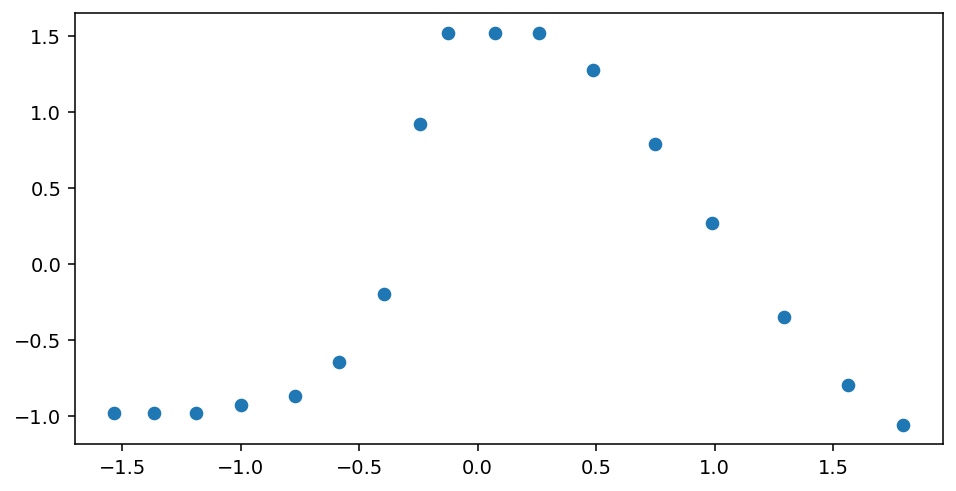

In [57]:
fig, ax = plt.subplots()
ax.scatter(pts[:,0], pts[:,1])

How could we find a (polynomial) curve that goes through them? That is, find a $\theta$ vector that when we pass it to `poly_predict()` closely approximates these data points? 

The example below shows an example `theta` (not very good) and the corresponding predictions.

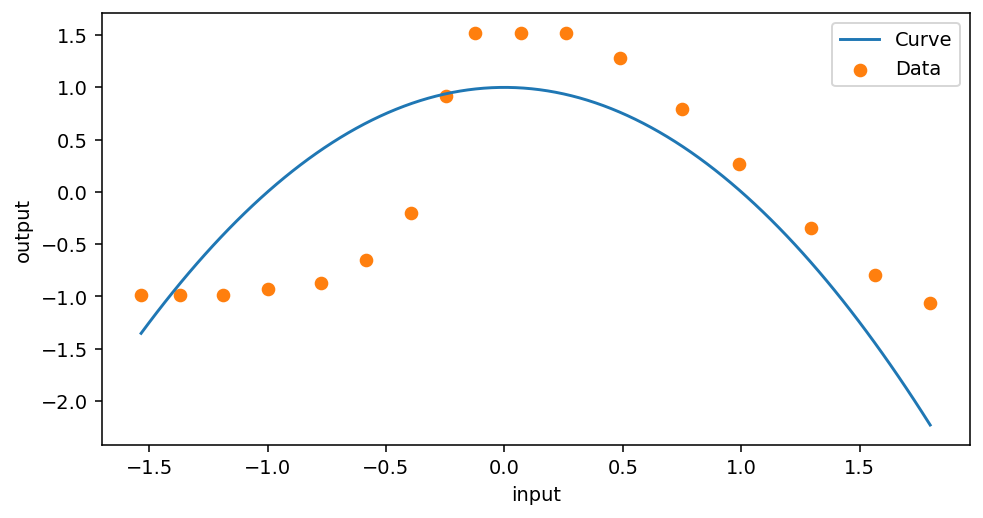

In [58]:
def show_curve(theta):
    fig, ax = plt.subplots()
    xs = np.linspace(pts[:,0].min(), pts[:,0].max(), 100)
    y_pred = poly_predict(xs, theta)
    ax.plot(xs, y_pred, label="Curve")
    ax.scatter(pts[:,0], pts[:,1], label="Data", c='C1')
    ax.legend()
    ax.set_xlabel('input')
    ax.set_ylabel('output')
    
show_curve(theta=[1, 0, -1])

## A.1 Write an objective function
Write an objective function `poly_objective_function(theta)` that uses `poly_predict, pts` and `poly_loss` to return a single number for a given `theta`.


In [59]:
# YOUR CODE HERE
def poly_objective_function(theta):
    y_pred = poly_predict(pts[:, 0], theta)
    loss = poly_loss(pts[:, 1], y_pred)
    
    return loss
    

In [60]:
# evaluate the objective function with a range of values for theta
# check objective function values are close to true solution

def close(a, b):
    print(a,"->", b, "OK" if np.allclose(a,b) else "X")
    return np.allclose(a,b)
    
with tick.marks(4):    
    assert close(poly_objective_function(np.array([0])), 16.999832617699997)
    assert close(poly_objective_function(np.array([5,1,3,3])), 2649.8505173858325)
    assert close(poly_objective_function(np.array([5,-10,3,3,30])), 209575.48452298887)
    assert close(poly_objective_function(np.array([-5,-1,3,-3,0.1])), 1011.4756471422478)
    assert close(poly_objective_function(np.array([1, 2, -3, -1, 1])), 5.504899749098892)

16.999832617699997 -> 16.999832617699997 OK
2649.8505173858325 -> 2649.8505173858325 OK
209575.48452298887 -> 209575.48452298887 OK
1011.4756471422478 -> 1011.4756471422478 OK
5.504899749098892 -> 5.504899749098892 OK


### A.2 Grid search: evaluating solutions at regular intervals

One solution would be to use grid search, iteratively evaluating $\theta$s that are evenly spaced within the feasible set along each dimension and keeping the best solution found so far. Write code that does this, calling your function `grid_search(obj_fun, ranges, n_candidates)` that takes an objective function, an array `ranges` of shape $(N, 2)$ specifying the minimum and maximum value for $\theta$ along each dimension, and an array `n_candidates` of shape $(N,)$ specifying the number of different $\theta$ values to evaluate along each dimension. 

Do not try and use `History`. Write the code from scratch in NumPy. Do not hardcode the objective function.

**Write a general grid_search function -- do not hardcode poly_objective_function!**

In [61]:
def grid_search(obj_fun, ranges, n_candidates):
    n_dimensions = len(ranges)
    
    values = [np.linspace(ranges[i, 0], ranges[i, 1], n_candidates[i]) for i in range(n_dimensions)]
    value_sets = np.array(np.meshgrid(*values)).T.reshape(-1, n_dimensions)
    
    best_theta = None
    best_value = float('inf')
    
    for value in value_sets:
        val = obj_fun(value)
        
        if val < best_value:
            best_value = val
            best_theta = value
            
    return best_theta
    

print(np.array([-3,3]*5).reshape(5, 2))
print(np.array([7]*5))


[[-3  3]
 [-3  3]
 [-3  3]
 [-3  3]
 [-3  3]]
[7 7 7 7 7]


Testing results...


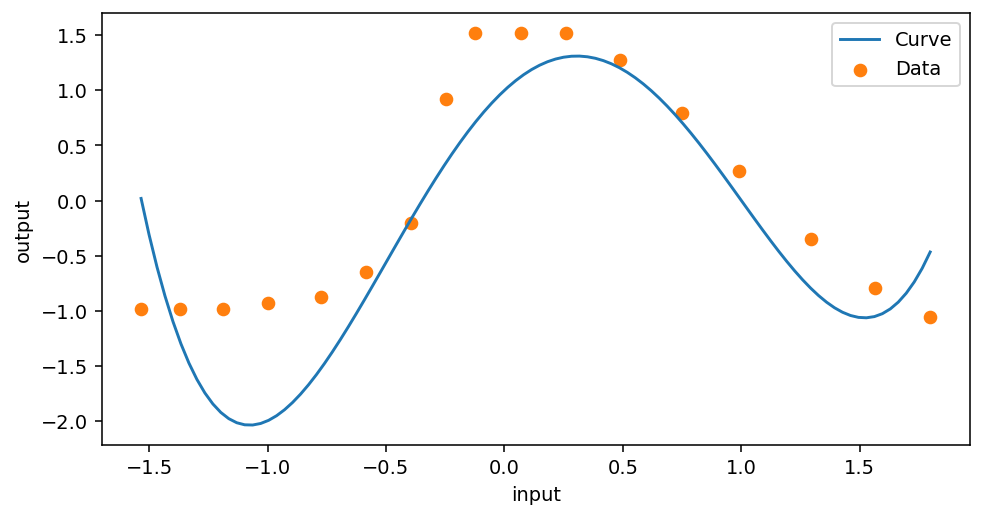

In [62]:
l = lambda t: np.sum([((t[i]-i)/6)**2 for i in range(len(t))])
grid_search(l, np.array([-3,3]*4).reshape(4, 2), np.array([7]*4)) # test it works for another objective function
    
# check that the general function works
with tick.marks(4):

    def eval(l, r, n):
        theta = grid_search(l, r, n)
        return l(theta), theta
    
    print("Testing results...")

    for r, n, y in zip([[-1,1], [-2,2], [-3,3]], [9, 9, 7], [0.3888888888888889, 0.1388888888888889, 0.027777777777777776]):
        r, n = np.array(r*5).reshape(5, 2), np.array([n]*5)
        assert np.allclose(y, eval(l, r, n)[0])
    
# show the best fit       
theta_grid = grid_search(poly_objective_function, np.array([-3,3]*5).reshape(5, 2), np.array([7]*5))
show_curve(theta_grid)

## A.3: Hyperparameter Search

Grid search doesn't assume that parameters are continuous-valued or that the objective function is smooth. Therefore, it is not a particularly good optimisation algorithm for problems where these assumptions hold. It is, however, being used frequently for optimising _hyperparameters_; the parameters that affect the behavior of an optimisation algorithm.

The algorithm below implements hill-climbing and has two hyperparameters: `limit` affects the interval within which $\theta$ is initialised, and `delta` controls the magnitude of changes made to $\theta$ in every iteration.

best loss at the end of hill-climbing: 75.97429465275447


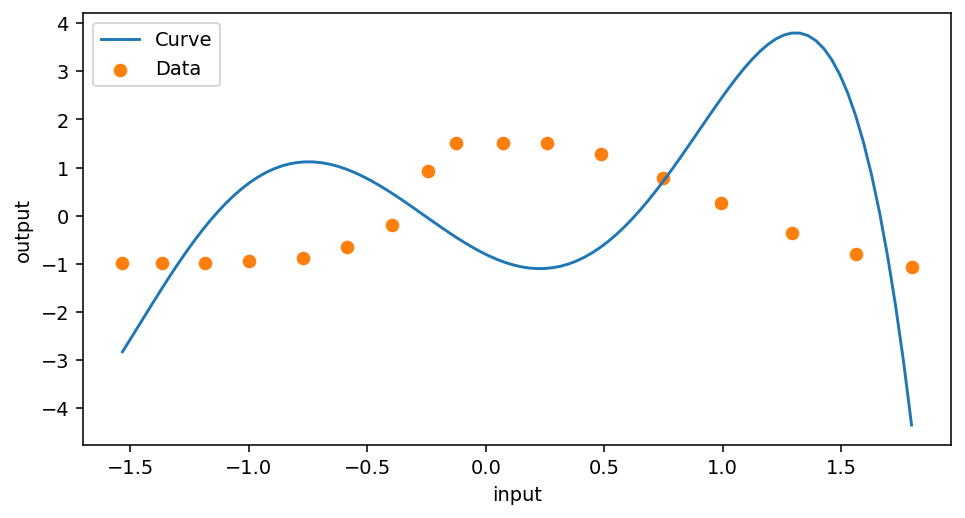

In [63]:
def get_init_fn(limit):
    # this function returns a function init_fn with a fixed range
    return lambda: rng.uniform(-limit, limit, 6)

def get_proposal_fn(delta):    
    # this function returns a function proposal_fn with a fixed delta
    return lambda x: x+rng.uniform(-delta, delta, x.shape)
    
def hill_climbing(l, max_iters, init_fn, proposal_fn):    
    best_guess = init_fn()    
    best_loss = l(best_guess) # work out how bad it is    
    
    for i in range(max_iters):                
        proposed = proposal_fn(best_guess)   
        proposed_loss = l(proposed)
        # check if we beat the record
        if proposed_loss<best_loss:
            best_guess, best_loss = proposed, proposed_loss            
    
    return best_guess, best_loss

init_fn = get_init_fn(limit=5)
proposal_fn = get_proposal_fn(delta=2.)
theta, loss = hill_climbing(poly_objective_function, 1_000, init_fn, proposal_fn)
show_curve(theta)
print(f'best loss at the end of hill-climbing: {loss}')

Write code that uses your previous function `grid_search` to optimise the hyperparameters of the `hill_climbing` algorithm. 

Write a function `hill_climbing_loss(params)` that takes hyperparameters `params`, where `params[0]` specifies the `limit` and `params[1]` specifies the `delta`. The function should call `hill_climbing` with `poly_objective_function` as loss, and run it $1000$ iterations. For robust results, this should be repeated 10 times and the mean loss at the end of hill-climbing across across repetitions should be returned. 

Store the best parameters identified by your grid search in `best_params`.

In [64]:
def hill_climbing_loss(params):
    limit = params[0]
    delta = params[1]
    total_loss = []
    n_repeat = 10
    for _ in range(n_repeat):
        init_fn = get_init_fn(limit)
        proposal_fn = get_proposal_fn(delta)
        
        best_guess, best_loss = hill_climbing(poly_objective_function, 1000,  init_fn, proposal_fn)
        total_loss.append(best_loss) 

    
    return np.mean(total_loss)

best_params = grid_search(hill_climbing_loss, np.array([0, 0.02]*2).reshape(2, 2), np.array([5]*2))        


mean loss 1.2551696403887695
standard deviation 0.0023611049176082925


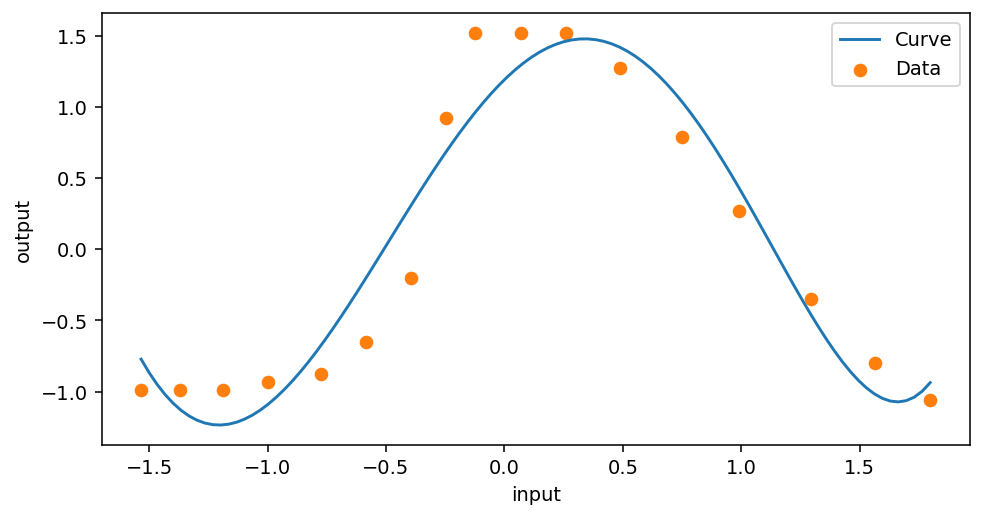

In [65]:
with tick.marks(4):
    losses = [hill_climbing(poly_objective_function, 10_000, get_init_fn(best_params[0]), get_proposal_fn(best_params[1]))[1] for _ in range(10)]
    print(f'mean loss {np.mean(losses)}')
    assert(np.mean(losses) < 1.5)
    print(f'standard deviation {np.std(losses)}')
    assert(np.std(losses) < 0.01)

theta, loss = hill_climbing(poly_objective_function, 10_000, get_init_fn(best_params[0]), get_proposal_fn(best_params[1]))
show_curve(theta)

## Differentiability 

Grid search takes a very long time and often fails to optimise even a small number of paramaters, whereas well-tuned hill-climbing produces useful results by exploiting the continuity of the parameter space the continuity of the objective function. We can do much better, however.

If we can differentiate `l` then we can use **gradient descent** to solve the problem, using the algorithm:

$$\vec{\theta^{(i+1)}} = \vec{\theta^{(i)}} - \delta \nabla L(\vec{\theta^{(i)}})$$

(or `new_guess = old_guess - step_size * gradient_at(old_guess)`, in code)

`autograd` makes this trivially easy, and can automatically compute the derivatives of our code:

In [66]:
# compute gradient of l with respect to theta
## IMPORTANT: grad() takes a *function* and returns a function 
# that evaluates the derivative instead
l = poly_objective_function
grad_l = grad(l)

In [67]:
# this will be a vector, with as many dimensions as theta
theta_0 = np.zeros(6)
print(grad_l(theta_0))

[ 0.00002    -8.10433937 24.03910117  0.02412798 56.81879459 23.00552409]


The result is a **vector** which points in the direction where the objective function should be increasing. We can try moving a small amount in the opposite direction, computing the loss as we go:

1.2855562903292954


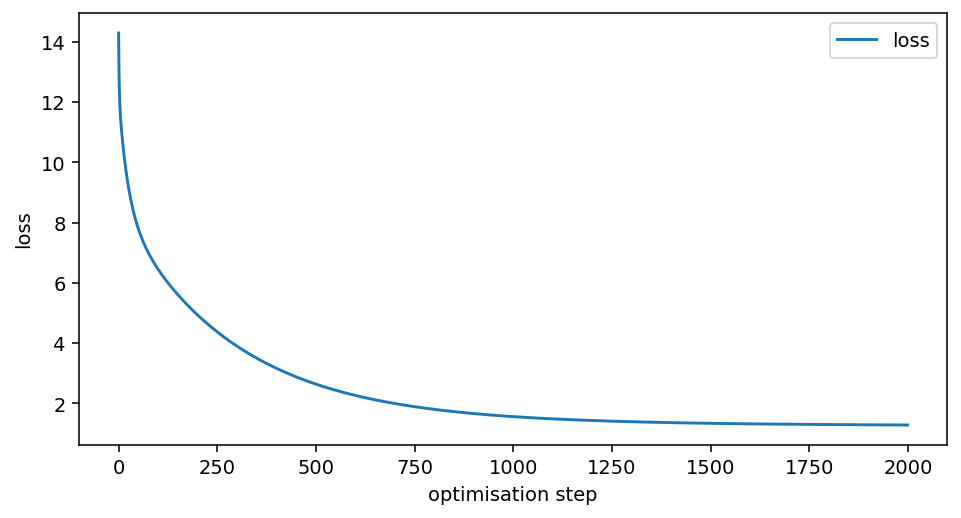

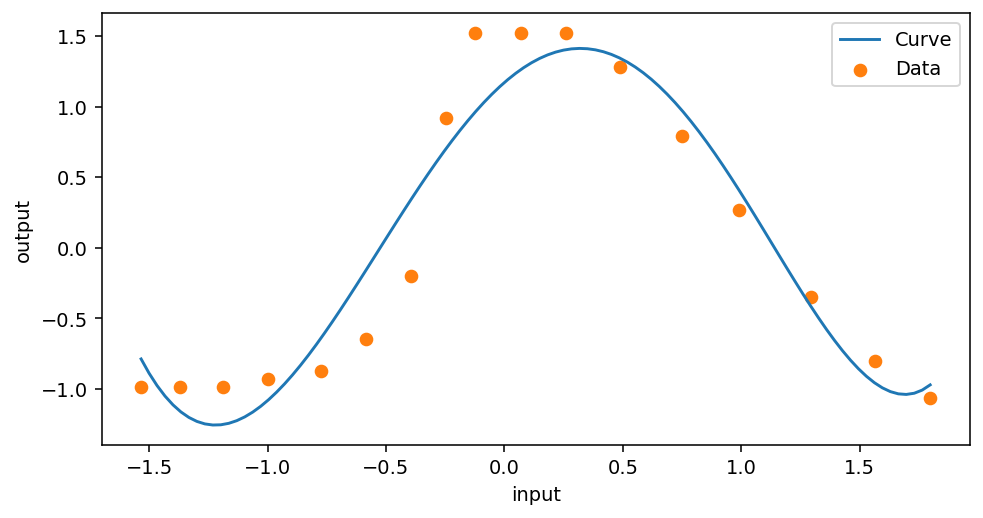

In [68]:
delta = 0.001 # how big of steps to take
losses = []
theta = theta_0

for i in range(2_000):
    theta = theta - delta * grad_l(theta)
    losses.append(l(theta))

fig, ax = plt.subplots()
ax.plot(losses, label='loss')
ax.legend()
ax.set_xlabel('optimisation step')
ax.set_ylabel('loss')

print(losses[-1])
show_curve(theta)

This quickly reduces the objective function value, and gets very close to the true solution. While hill-climbing took tens of thousands of iterations for hyperparameter tuning and optimisation, and grid search never found a good solution, this approach reliably finds a very good solution in only  2000 iterations.

# The head orientation problem

Given an image of a human head, can we predict its pose? For example, the head in the image below is rotated by 30 degrees around the vertical axis (yaw) and by 1 degree around the horizontal axis (pitch).

<img src="new_data/face_0000.png">

Running the code cell below will show more examples.

How can we use optimisation to solve this problem? We need to have a *parameterisable function* that somehow maps from images to poses, and then adjust the parameters until the function maps head images onto head phases. 

That is, we want to find some function $f$ that takes an image as input, and outputs a head pose as output. $f$ must be configurable with a vector of parameters $\theta$.

#### Approximation
We will be trying to approximate a function. This means we have an objective function of the form:

$$L(\theta) = \|f(\vec{x};\theta)-y\|$$

where we measure the difference between a predicted output $f(\vec{x};\theta)$ and a real, expected output $y$, and try and minimise that difference by choosing a good setting for $\theta$.

We will build a simple "deep learning" system. We will completely ignore many of the important problems in machine learning, like overfitting, regularisation, efficient network architectures and fair evaluation,  and concentrate on using first-order optimisation to find a function that approximates a known transformation.

### Loading the data
There are 698 head images concatenated horizontally in the file `new_data/face_strip.png`. Each image is 64x64 pixels, grayscale.

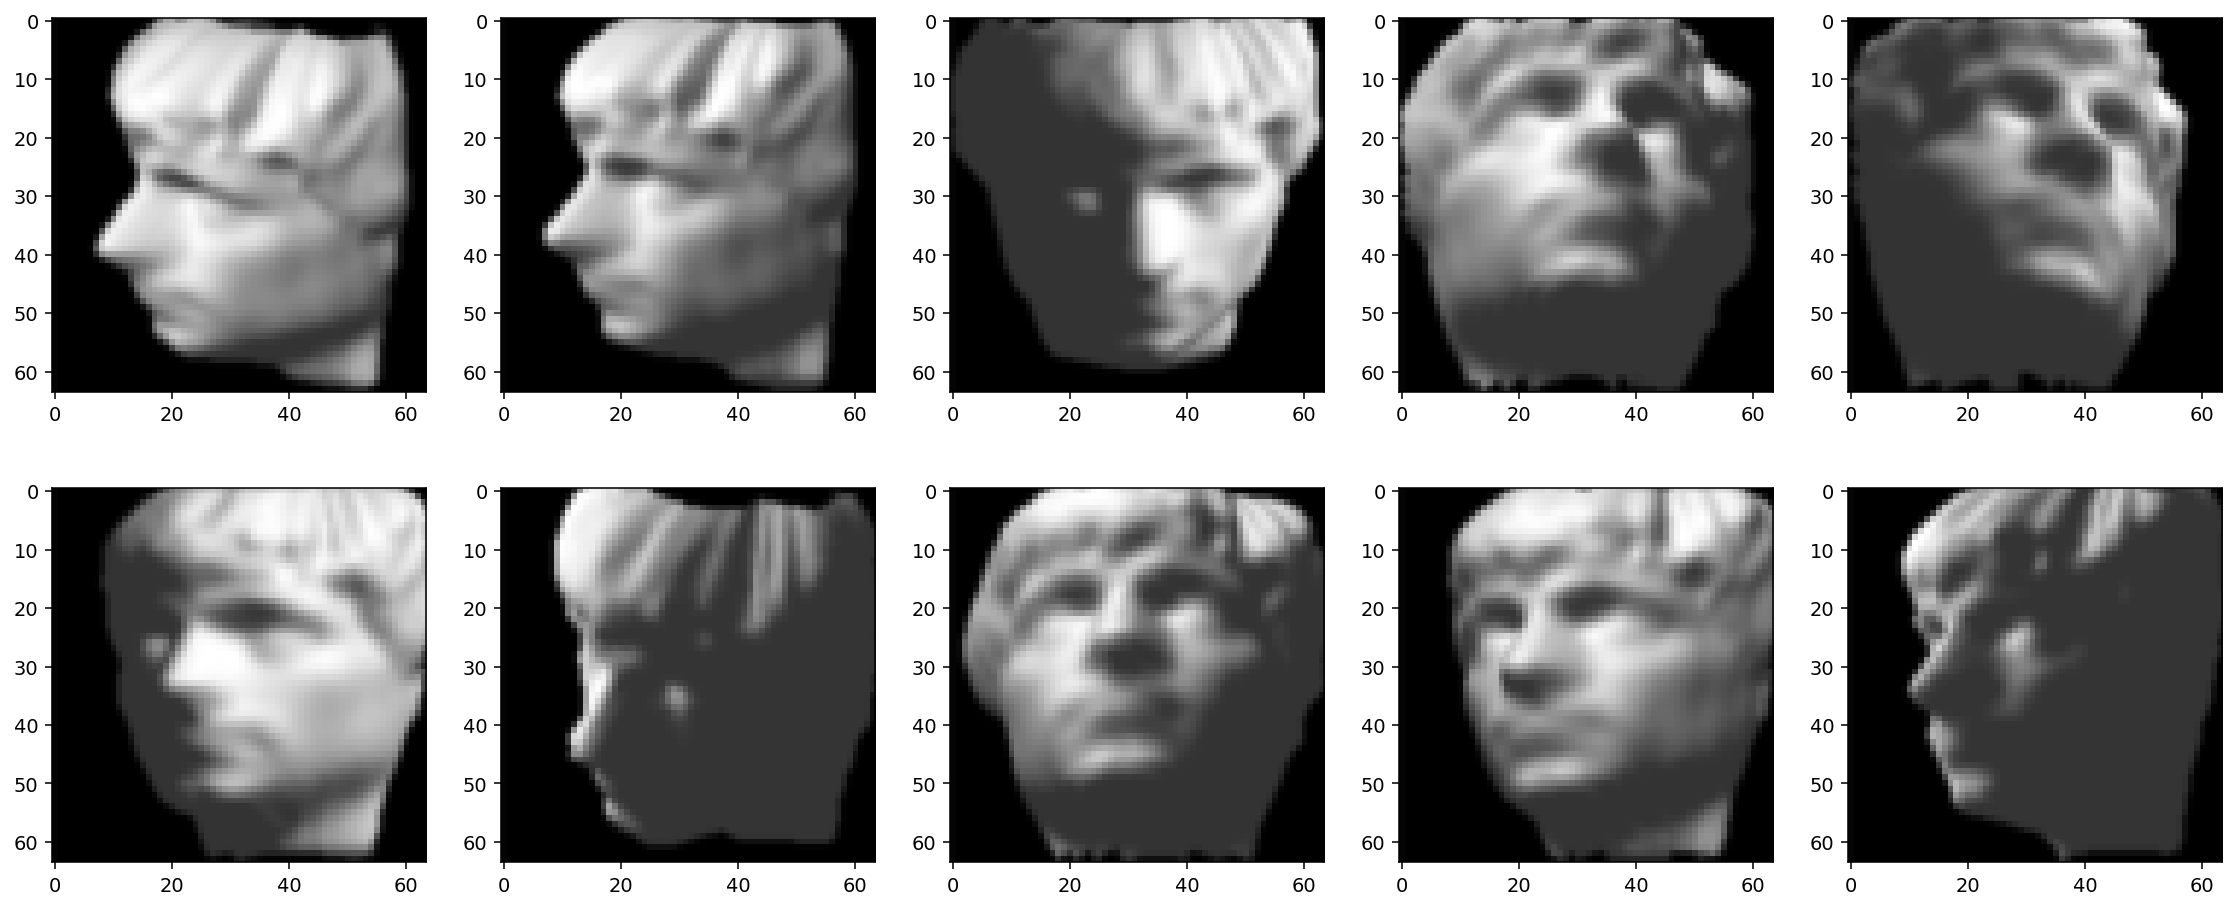

In [69]:
face_strip = ia.load_image_gray('new_data/face_strip.png')

def show_face(face, o=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()
        
    ax.imshow(face, cmap='gray')
    if o is not None:
        ax.set_title(f'yaw: {o[0]:.2f}, pitch: {o[1]:.2f}')

fig, _ = plt.subplots(2, 5, figsize=(5*4, 2*4))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    idx = rng.choice(698)
    show_face(face_strip[:,idx*64:(idx+1)*64], ax=ax)

### Step 1. Prepare the data
* Rearrange the data into a 3D tensor (image, pixel row, pixel_column)
* Subsample the data to retain only every 2nd row and every 2nd column. You should now have a 698x32x32 tensor.
* Normalize the images to values in the interval [0,1].
* Store the result in `faces`

In [70]:
# YOUR CODE HERE
print(face_strip.shape)
tensor_3d = face_strip.reshape(64, 698, 64)
tensor_ordered = np.einsum('abc -> bac', tensor_3d)

subsample = tensor_ordered[:, ::2, ::2]
print(subsample.shape)

faces = (subsample-np.min(subsample))/(np.max(subsample)-np.min(subsample))
print(faces.shape)
# faces = subsample / 255

(64, 44672)
(698, 32, 32)
(698, 32, 32)


In [71]:
with tick.marks(4):
    print(array_hash(faces))
    assert(check_hash(faces, ((698, 32, 32), 87092746113.979257)))

((698, 32, 32), 87092746113.97925)


You'll see a selection of low-res images below.

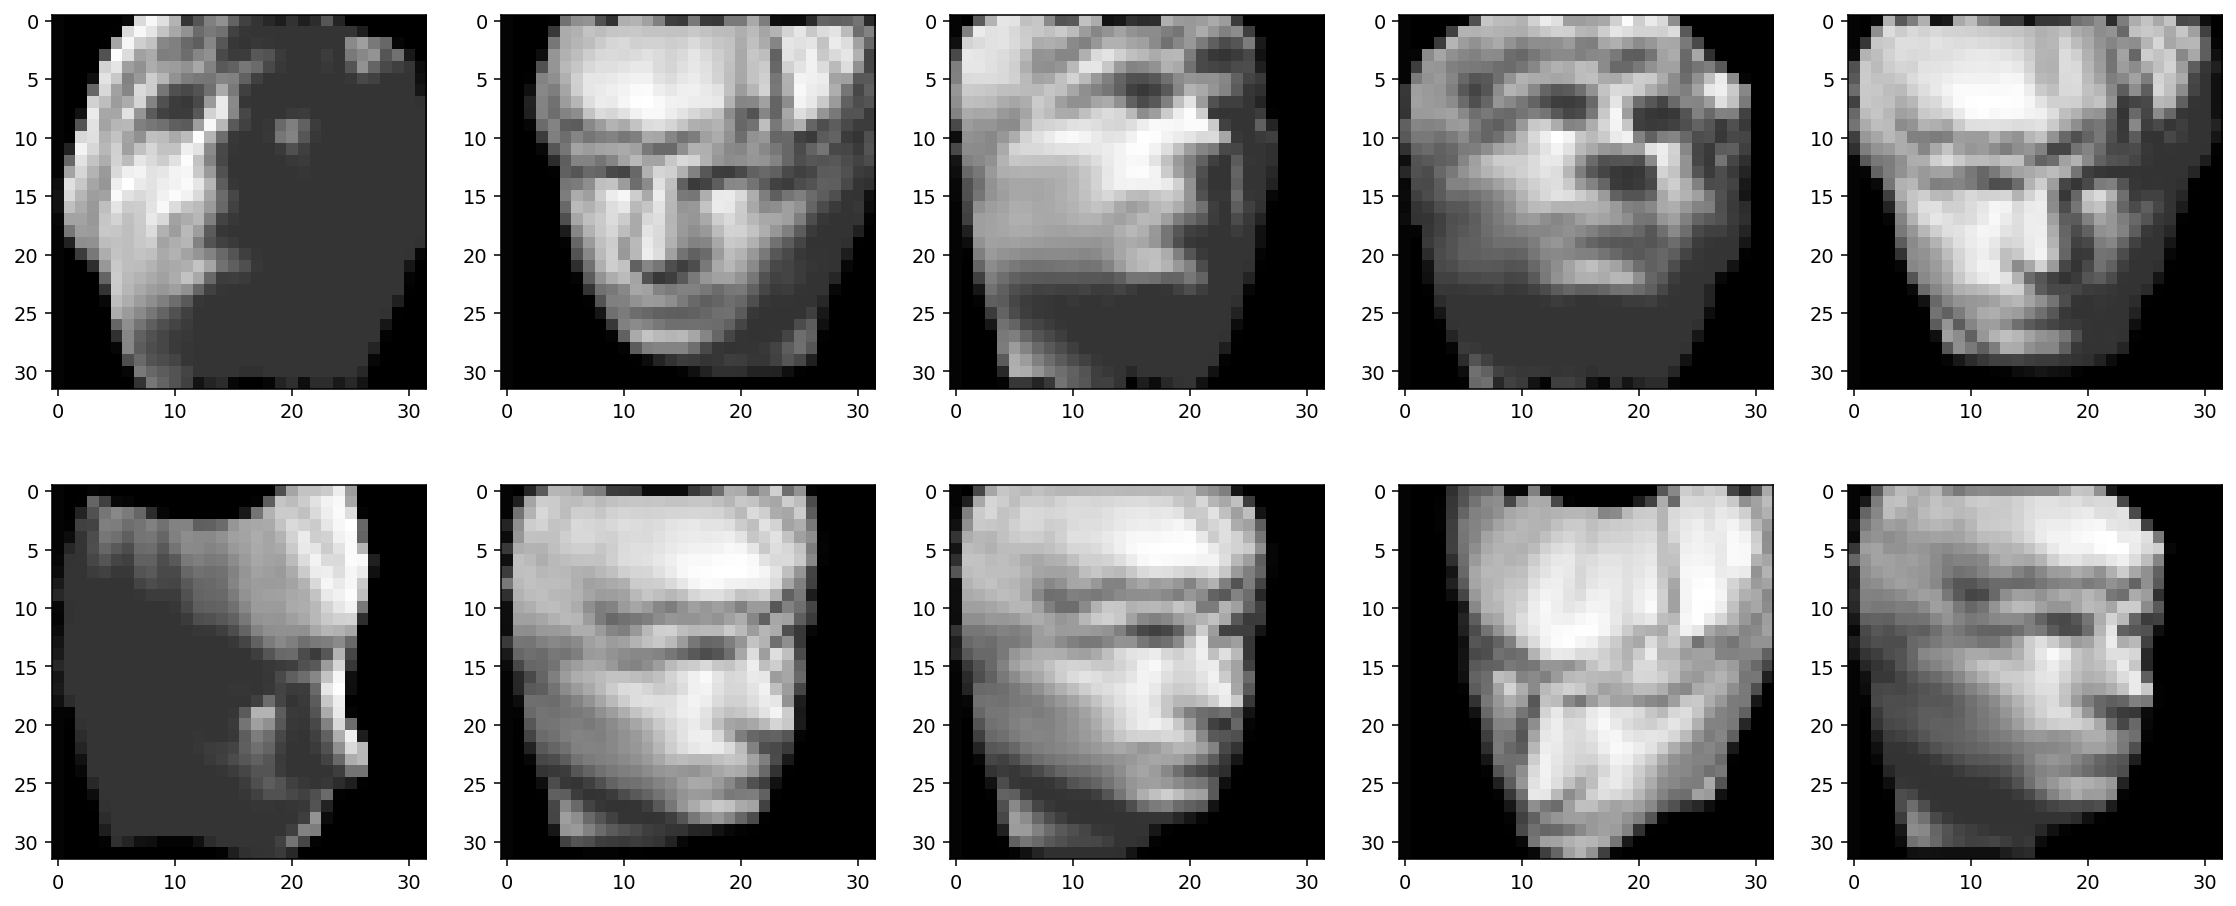

In [72]:
fig, _ = plt.subplots(2, 5, figsize=(5*4, 2*4))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    idx = rng.choice(698)
    show_face(faces[idx], ax=ax)

## Image vectors

We have to be able to write this problem in the form:

$$L(\theta) = \|f(\vec{x};\theta)-\vec{y}\|$$

Every input vector $\vec{x}$ must have a corresponding matched expected output $\vec{y}$, and we need a function $f$ that depends on $\vec{x}$ and $\theta$.

### Inputs
What is $\vec{x}$? How can we define the input to this function? We need to have one vector per example; that is a matrix with one row per face image. We can do this by reshaping the `faces` tensor to unravel the 32x32 pixel image into a single 1024 dimensional vector.

### Step 2
Reshape the faces tensor to a 698x1024 matrix; each row being a face image as a single "unravelled" vector. Store this in `faceputs`.

In [73]:
# YOUR CODE HERE
faceputs = faces.reshape(698, 1024)

In [75]:
with tick.marks(4):
    print(array_hash(faceputs))
    assert(check_hash(faceputs,((698, 1024), 87092746113.97925)))

((698, 1024), 87092746113.97925)


### The expected outputs
$\vec{y}$ will be the *known* head orientation for each image. 

The file `new_data/face_pose_degrees.txt` contains two rows, with yaw angles delimited by space in the first row and pitch angles delimited by a space in the second row. Load the data with `np.loadtxt` and store the yaw angle in a (698, ) tensor called `yaw_outputs`.


In [76]:
# YOUR CODE HERE
data = np.loadtxt('new_data/face_pose_degrees.txt')

yaw_outputs = data[0]

In [77]:
# test that the result is corrected
with tick.marks(4):
    print(array_hash(yaw_outputs))
    assert(check_hash(yaw_outputs, ((698, ), -650896.1407226154)))

((698,), -650896.1407226154)


If you have done this correctly, when you run the code below you will see the face images shown in a map below, heads facing left to the left, heads facing right to the right. It should look like the following:

<img src="imgs/face_orientations.png" width="80%">

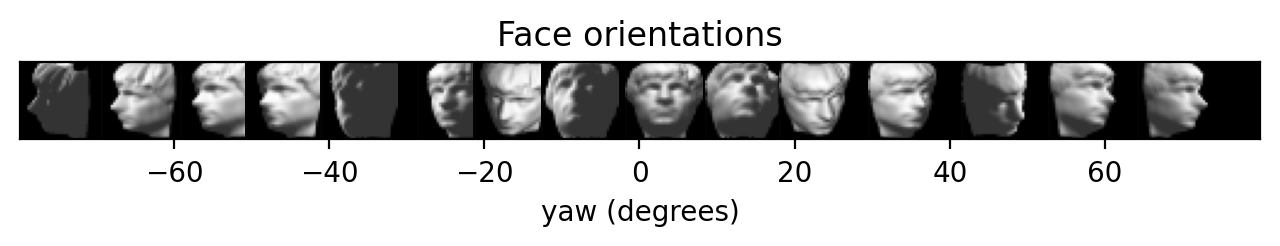

In [80]:
def show_faces(images, orientations):
    # show the faces, and their orientation
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1,1,1)
    ax.set_facecolor('k')
    sz = 5
    idx = np.argsort(orientations)
    for i in idx[::48]:
        
        pos = orientations[i]
        
        ax.imshow(images[i].reshape( (faces.shape[1],faces.shape[2]) ), extent=[pos-sz, pos+sz, -sz, +sz], vmin=0, vmax=1, cmap='gray')

    ax.set_xlim(np.min(orientations)-sz,np.max(orientations)+sz)
    ax.set_ylim(-sz,sz)
    ax.set_yticks([])
    ax.set_title("Face orientations")
    ax.set_xlabel('yaw (degrees)')
    
# apply to the *known* inputs and outputs; will be a perfect circle    
show_faces(faceputs, yaw_outputs)


## A deep network
How will this parameterisable function that maps from images to orientations be defined? We will use a very simple deep "neural network" predictor. This is an incredibly simple algorithm. It takes a vector, then repeatedly:

* adds a small constant
* applies the `ReLU` (Rectified Linear Unit) non-linearity of the resulting vector; this allows the network to learn non-linear functions
* multiplies the vector by a (different) matrix

We have to define the *shape* of each of the matrices which will be used to transform the vector, but we *optimise* to find the elements that go into those matrices. This is the "learning" part.

Each of these steps is traditionally called a "layer" of the prediction function.

In [82]:
# a very basic neural network
# the only slightly subtle thing is the unflattening, which is explained below
def predict(theta, x, unflatten):        
    for w in unflatten(theta):          
        x = w.T @ np.maximum(0, x)
    return x

### Flattening and unflattening
<div class="alert alert-box alert-danger"> 
    
**READ THIS SECTION CAREFULLY**

    
</div>

To be able to optimise this prediction function in the standard form, we have to package *all* of the things that could vary into a single "flat" parameter vector $\theta$. `predict()` can unpack a list of matrices from a single vector if it is given the right `unflatten` parameter. We can use the `flatten` convenience function to make this easy; this is provided by **autograd**.

    theta, unflatten = flatten(list_of_matrices)

takes a list of matrices `list_of_matrices` and returns them packed into a single 1D NumPy vector `theta` along with `unflatten`, a function which will reverse that process and unpack all the matrices when applied to `theta`.

`flatten` is like a "super-ravel" which can be reversed by the `unflatten` function which it returns. Note: `unflatten` is not in any way "attached" to the data. It is simply a function which knows how to unpack a list of matrices of certain shapes from a single parameter vector.

See the examples below:

In [83]:
# create a list of matrices
list_of_matrices = [np.zeros((3, 3)), np.ones((2, 4)), np.full((1, 4), 2.0)]
print(list_of_matrices) 

[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[2., 2., 2., 2.]])]


In [85]:
# convert to a flat vector
# along with a *function* which will later unflatten theta back into a list of matrices
theta, unflatten = flatten(list_of_matrices)

In [86]:
# the flattened version; a single vector
print(theta)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.]


In [87]:
# restore the flattened version to original shapes
print(unflatten(theta))

[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[2., 2., 2., 2.]])]


### Objective function

**Task B.4**

Write an objective function that will compare the predicted output to the expected output, for one set of input and output vectors, given `theta`, `unflatten`, `x` and `y`. Use the $L_2$ norm. The function should be of the form

    def loss(theta, unflatten, x, y):
        ...
        return l # a scalar
        
The loss function will need to call `predict` to calculate `y_prime`, the predicted output to compare with `y`. Assume `x` and `y` are vectors. 

In [88]:
def loss(theta, x, y, unflatten):
    theta_unflatten = unflatten(theta)
    y_prime = predict(theta, x, unflatten)
    
    l2 = np.linalg.norm(y_prime - y)
    
    return l2
    

In [89]:
# create a random set of weights, and test that the loss function is computed correctly
test_network = [
    np.array([[1, 0.5, -0.5], [0.0, 2.0, -1.0]]).T,
    np.array([[2.0, 1.0], [1.0, -1.0]]).T,
]

theta, unflatten = flatten(test_network)

with tick.marks(4):
    assert (
        abs(loss(theta, np.array([1, 2, 3]), np.array([-1, 1]), unflatten) - 3.35) < 0.1
    )

### Network architecture
The choice of the matrix shapes we use to do the prediction affects how well we will be able to model the transformation. In our example, we know we have 1024 dimensional inputs (32x32 face images unraveled into flat vectors) and 1 dimensional outputs (the yaw vectors we generated above). So the we must start with 1024 dimensional vectors and end up with 1 dimensional vectors. However, we can introduce any number of intermediate matrices into the prediction function. This gives more parameters that could be tweaked, and more flexibility in how the mapping is learned; it makes the prediction function more *flexible*.

A very simple model might have a single 1024,1 matrix; this would be a simple linear transformation of the inputs.

    W[0]
    1024, 1

A more complex model might have a mapping with:

    W[0]       W[1]    W[2]
    1024,32 -> 32,8 -> 8,1

This "architecture" maps the 1024 input vector to some 32 dimensional space, then to some 8 dimensional space, then to the 1 dimensional output. Every matrix has to have an output dimension which matches the input dimension of the following matrix. The matrices W[0], W[1], W[2] specify how the vector at each layer gets mapped to the next layer. All of these matrices `W[i]` are flattened into a single vector `theta` for optimisation -- this is just a reshaping of their elements.


We *don't know* what values should go into these matrices; they specify some unknown transformation of the vectors in each step. We have to optimise to find the elements of these matrices.

                 W[0]   W[1]  W[2]
    (input) 1024D -> 32D -> 8D -> 1D  (output)

The choices of these matrix shapes are not hugely important (I just made the ones above up); but more matrices with more elements means a more flexible function which can learn more complicated things; but will be harder to optimise efficiently.

For this lab, assume that the matrix shapes to be used are:

    1024,32  32,8  8,1

This will work well, without being too hard to optimise. You can alter this if you want, but the above version is known to work.

### Task: initialisation
We need to set up some *initial conditions* for the optimisation process. We can define the shape of each matrix, but we don't know what the values of the elements in the matrices should be, because we will find this by optimisation. So we just make a random guess.

* Create a function that generates initial conditions for the prediction function. 
* This function should take a list of matrix *shapes*, and create a corresponding list of randomly filled matrices.  
* Each matrix generated should have the specified shape.  
* The function should take a parameter `sigma` that should specify the spread of the random values chosen.
* The function shuold take a random number generator `rng` used to generate random values.

Use `rng.normal(0, sigma, shape)` to generate the random numbers.

Return the **flattened** version of the matrix list, along with the corresponding `unflatten` function.

Your function should have the form:
    
    def initial_conditions(shape_list, sigma_list, rng):
        ...
        return theta, unflatten        

For example `initial_conditions([[2,3], [3,6]], [0.1, 0.1], rng)` should return the flattened version of a `(2,3)` and `(3,6)` shape random matrices.

In [90]:
def initial_conditions(shape_list, sigma_list, rng): 
    matrices = []
    for shape, sigma in zip(shape_list, sigma_list):
        matrix = rng.normal(0, sigma, shape)
        matrices.append(matrix)
            
    theta, unflatten = flatten(matrices) 
    
    return theta, unflatten
    

In [91]:
theta, unflatten = initial_conditions([[8,4], [4,8], [2,4]], [0.1]*3, rng)
matrices = unflatten(theta)
with tick.marks(4):
    assert(matrices[0].shape==(8,4))
    assert(matrices[1].shape==(4,8))
    assert(matrices[2].shape==(2,4))

## Random predictions
We can use predict to see the effect of applying this function to the face images. Since all of the matrices are random, the result will be a random mess. If the the matrices were optimised, we would see all face images along the diagonal (bottom,left) to (top, right) of the plot suggesting the predicted yaw angle is similar to the target yaw angle across the dataset.

Text(0.5, 1.0, 'Random predictions')

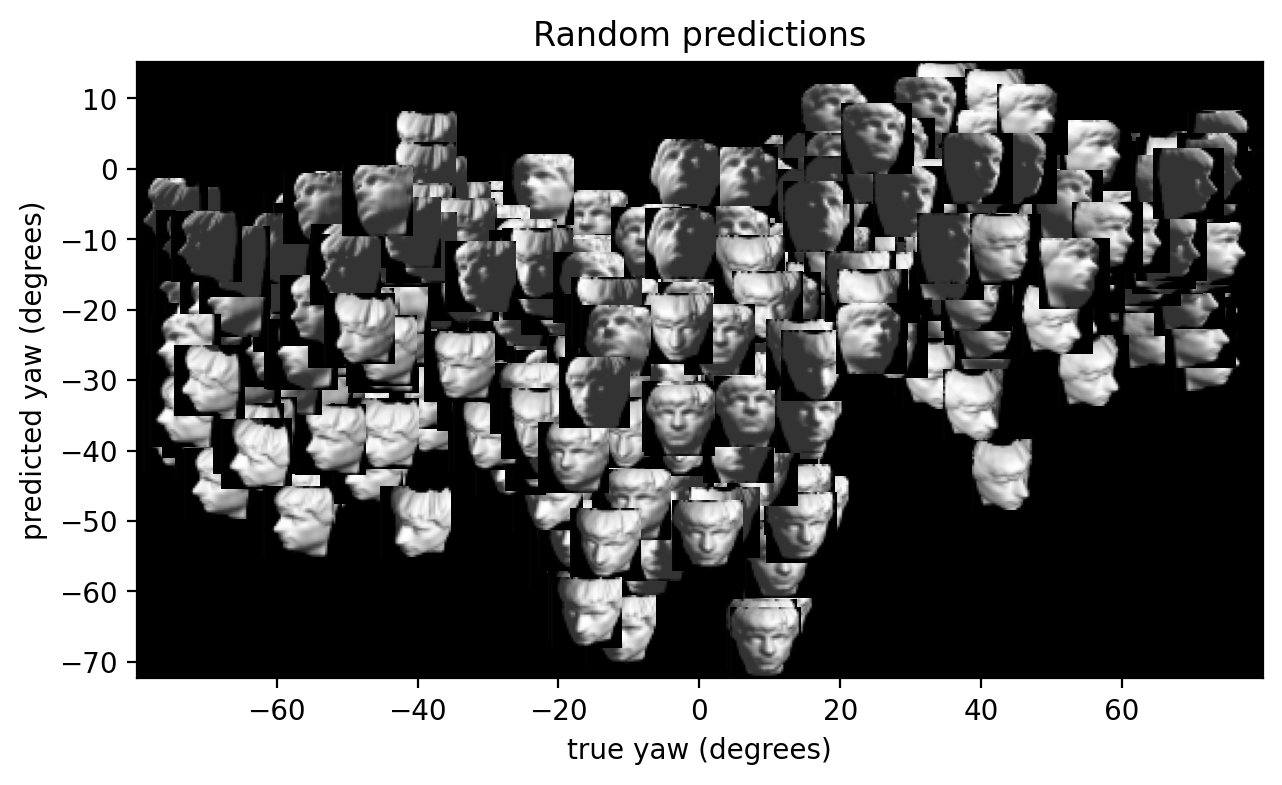

In [136]:
# create some test initial conditions
random_theta, unflatten = initial_conditions( [[1024,32], [32, 8],  [8,1]], [1, 1, 1], rng)
# predict the outputs (will be random junk)
predicted_outputs = [predict(random_theta, faceputs[i], unflatten) for i in range(faceputs.shape[0])]

def show_face_predictions(images, true_yaw, prediction):
    # show the faces, and their orientation
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1,1,1)
    ax.set_facecolor('k')
    sz = 5
    # idx = np.argsort(orientations)
    for i in range(images.shape[0]): #idx[::48]:
        x = true_yaw[i]
        y = prediction[i]
        
        ax.imshow(images[i].reshape((faces.shape[1],faces.shape[2]) ), extent=[x-sz, x+sz, y-sz, y+sz], vmin=0, vmax=1, cmap='gray')

    ax.set_xlim(np.min(true_yaw)-sz,np.max(true_yaw)+sz)
    ax.set_ylim(np.min(prediction)-sz,np.max(prediction)+sz)
    ax.set_title("Face orientations")
    ax.set_xlabel('true yaw (degrees)')
    ax.set_ylabel('predicted yaw (degrees)')
    
show_face_predictions(faceputs, yaw_outputs, np.array(predicted_outputs).reshape(-1))
plt.gca().set_title("Random predictions")

**Task** Write a function `total_face_loss` that computes the sum of the objective function value for *every* matched input and output pair from `faceputs` and `yaw_outputs`.  That is, it computes:

$$L(\theta) = \sum_i \|y'_i - f(\vec{x_i};\theta)\|$$

where $x_i$ is the ith row of `faceputs`, $y_i$ is the ith row of `yaw_outputs` and `theta` is the parameter vector. The function must also take an `unflatten` argument so it can unpack the parameter vector correctly. **This function should use the `loss` function you defined above**

In [137]:
# compute the sum of losses
# for every pair of xs and ys
def total_face_loss(theta, unflatten):
    total_loss = 0
    for x, y in zip(faceputs, yaw_outputs):
        current_sum = loss(theta, x, y, unflatten)
        total_loss+=current_sum

    return total_loss
    

In [138]:
rng_test = np.random.default_rng(2023)

# create some test initial conditions
random_theta, random_unflatten = flatten([rng_test.normal(0,1,(1024,4)), rng_test.normal(0,1,(4,1))])

with tick.marks(2):    
    assert(np.allclose(total_face_loss(random_theta, random_unflatten), 27791.649556595046, atol=1e-1))

## Gradient descent learning

Now we will optimise with gradient descent, and get a much better result.  In this task, you will have to define a function `sgd_learn`. This will perform a simple form of (stochastic) gradient descent.

## Differentiation

Using automatic differentiation provided by `autograd`, compute the derivative of the loss function `loss` (the loss function for *one* single example you defined above), and call it `grad_face_loss`. Hint: this is trivial.

In [139]:
# YOUR CODE HERE
grad_face_loss = grad(loss)

In [140]:
rng_test = np.random.default_rng(2023)

# create some test initial conditions
random_theta, random_unflatten = flatten(
    [rng_test.normal(0, 1, (1024, 4)), rng_test.normal(0, 1, (4, 1))]
)
print(np.sum(grad_face_loss(random_theta, faceputs[0], yaw_outputs[0], 
                            random_unflatten
                           )))
with tick.marks(4):
    assert np.allclose(np.sum(grad_face_loss(random_theta, faceputs[0], yaw_outputs[0],
                                             random_unflatten
                             )), 412.05403331128605, atol=1e-1)
        

412.0540333112861


**Task** 

Now define a function to perform stocahstic gradient descent.

`sgd_learn(shapes, inputs, outputs, sigmas, rng, step, iters)` should:

* take a list of matrix `shapes`, a list of `sigmas` to specify the random initialisation of those matrices, a `rng` random number generator, a `step` size and a number of `iterations`
* generate an initial `theta` from that set of shapes, using the `initial_condition()` function you defined above.
* for each of the given number of iterations
    * randomly select *ONE* input vector (from `inputs`) and matching output vector (from `outputs`).
    * compute the gradient of the objective function for that image/output pair
    * make a step, adjusting `theta` in the direction of this gradient, scaled by the step size
    * print the iteration count every 500 iterations so you can see that the function is running
correctly. 

* return the flattened vector and the corresponding unflatten function

The function definition should look like:

        def sgd_learn(shapes, inputs, outputs, sigmas, rng, step, iters):
            ...        
            return theta, unflatten

Note: You don't need to implement *any* sophistications like momentum or random restart. You don't need to collect the data into minibatches. The algorithm you implement should be very simple. (you can add these things if you want, but it is not necessary to pass all of the tests).

* You may also want to evaluate the objective function itself at each iteration, and print out the sum of the objective function value overs the last 100 iterations in your print statement (this is optional, but helps in tuning the performance; the number should go down as optimisation progresses).

In [141]:

def sgd_learn(shapes, inputs, outputs, sigmas, rng, step=0.1, iters=10000):
    theta, unflatten = initial_conditions(shapes, sigmas, rng)
    losses = []

    
    grad_face_loss = grad(loss)
    
    for i in range(1, iters+1):
        rand_num = rng.choice(len(inputs))
        x  = inputs[rand_num]
        y = outputs[rand_num]
        
        gradient = grad_face_loss(theta, x, y, unflatten)
        
        theta -= step * gradient
        
        print(theta)
        
        if (i%500 == 0):
            result = grad_face_loss(theta, x, y, unflatten)
            losses.append(result)
            print(result)  
            
               
     
    return theta, unflatten

In [142]:
# verify that the shapes come out right
with tick.marks(2):
    test_theta, test_unflatten = sgd_learn([[1024,1]], faceputs, yaw_outputs, [0.1]*3, rng, 0.1, 1)
    unflattened = test_unflatten(test_theta)
    assert(len(unflattened)==1)
    assert((unflattened[0].shape)==(1024,1))


[-0.17371492  0.02140069 -0.15566998 ...  0.07161185  0.03164909
 -0.0634943 ]


In [143]:
## verify that some learning happens
rng_test = np.random.default_rng(2023)
with tick.marks(4):
    np.random.seed(2019)
    test_theta, test_unflatten = sgd_learn([[1024,1]], faceputs, yaw_outputs, sigmas=[0.5], rng=rng_test, step=0.01, iters=0)
    before_losses = [loss(test_theta, x,y, test_unflatten) for x,y in zip(faceputs, yaw_outputs)]
    
    test_theta, test_unflatten = sgd_learn([[1024,1]], faceputs, yaw_outputs, sigmas=[0.5], rng=rng_test, step=0.01, iters=500)
    after_losses = [loss(test_theta, x,y, test_unflatten) for x,y in zip(faceputs, yaw_outputs)]
    print("Mean loss before optimising %.2f; after optimising %.2f" % (np.mean(before_losses),  np.mean(after_losses)))
    assert(np.mean(after_losses)/np.mean(before_losses)<0.5)
    print("Something was learned!")
    

[ 0.29732143 -0.15917719  0.46281457 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29715968 -0.15917719  0.46281457 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29732143 -0.15917719  0.46281457 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29715968 -0.15917719  0.46281457 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29699794 -0.15917719  0.46273476 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29683619 -0.15917719  0.46273476 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29667445 -0.15917719  0.46273476 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.2965127  -0.15917719  0.46273476 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29635096 -0.15917719  0.46273476 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.2965127  -0.15917719  0.46273476 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29635096 -0.15917719  0.46273476 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29618921 -0.15917719  0.46273476 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29635096 -0.15917719  0.46926212 ... -0.23555122 -0.7825911


[ 0.29862699 -0.10979747  0.66557752 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29846525 -0.10979747  0.66557752 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.2983035  -0.10979747  0.66557752 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29846525 -0.10979747  0.66557752 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.2983035  -0.10979747  0.66557752 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29846525 -0.10979747  0.66557752 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29862699 -0.10979747  0.66657378 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29878874 -0.10979747  0.66657378 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29862699 -0.10979747  0.66318491 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29878874 -0.10979747  0.66318491 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29895048 -0.10979747  0.66330209 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29878874 -0.10979747  0.66322794 ... -0.23555122 -0.7825911
 -0.45122683]
[ 0.29895048 -0.10979747  0.66322794 ... -0.23555122 -0.7825911


**Task**

Use this function to learn an approximate mapping from face images to 1D vectors. You will have to choose:

* a **step size** (values in the range 0.1 to 0.0001 are reasonable)
* the **sigmas** for the initial conditions (values in the range 0.5 to 0.005 are reasonable, lower values make sense for a larger number of input or output dimensions).

These are **hyperparameters** of the optimisation process. 

* You should use *no more* than 20000 iterations in the learning process. 

**Warning: if your call to `sgd_learn` takes more than ten minutes to run, the autograder will not accept your result!**

Use matrix shapes `[[1024,32], [32, 8],  [8,1]]`, *or* choose your own set of matrix shapes (just don't make them so large the optimisation takes forever).


In [152]:
## Run sgd_learn(...) in this cell
## produce the output theta, unflatten
## theta, unflatten = learn(...
## LEAVE THIS HERE TO FORCE CONSISTENT RESULTS!
rng = np.random.default_rng(2023)
inputs = np.random.rand(100, 1024)
outputs = np.random.rand(100)
shapes = [[1024,32], [32, 8],  [8,1]]
sigmas = [0.5, 0.1, 0.005]
iters =  10000
theta, unflatten =  sgd_learn(shapes, faceputs, yaw_outputs, sigmas, rng, 0.001, iters)

# YOUR CODE HERE

[ 0.30086065  0.57580949 -0.67973118 ...  0.00639894  0.00868806
 -0.00722863]
[ 0.30086066  0.57580951 -0.67973119 ...  0.00710579  0.00868806
 -0.00722863]
[ 0.3008607   0.57580951 -0.6797312  ...  0.00710579  0.00868806
 -0.00722863]
[ 0.30086062  0.57580948 -0.67973117 ...  0.00679629  0.00868806
 -0.00722863]
[ 0.30086064  0.5758095  -0.67973118 ...  0.0070239   0.00868806
 -0.00722863]
[ 0.30086061  0.57580948 -0.67973117 ...  0.00669847  0.00868806
 -0.00722863]
[ 0.30086059  0.57580946 -0.67973115 ...  0.00616791  0.00868806
 -0.00722863]
[ 0.30086057  0.57580944 -0.67973113 ...  0.00432262  0.00868806
 -0.00722863]
[ 0.30086057  0.57580942 -0.67973112 ...  0.00425669  0.00868806
 -0.00722863]
[ 0.30086059  0.57580941 -0.67973112 ...  0.00219994  0.00868806
 -0.00722863]
[ 0.30086052  0.57580941 -0.67973112 ...  0.00269304  0.00868806
 -0.00722863]
[ 0.30086046  0.57580941 -0.67973111 ...  0.00450745  0.00868806
 -0.00722863]
[ 0.30086046  0.5758094  -0.6797311  ...  0.00450745

[ 0.30086188  0.57580982 -0.67973096 ...  0.03541533  0.00926336
 -0.01071647]
[ 0.30086153  0.57580988 -0.6797309  ...  0.03866725  0.00926336
 -0.01071647]
[ 0.30086185  0.57580981 -0.67973094 ...  0.03684931  0.00926336
 -0.01071647]
[ 0.30086151  0.57580987 -0.67973089 ...  0.03694604  0.00926336
 -0.01071647]
[ 0.30086151  0.57580994 -0.67973085 ...  0.03797849  0.00926336
 -0.01071647]
[ 0.30086181  0.57580987 -0.67973089 ...  0.03710752  0.00926336
 -0.01071647]
[ 0.30086215  0.5758098  -0.67973094 ...  0.03607365  0.00926336
 -0.01071647]
[ 0.30086095  0.57580973 -0.6797307  ...  0.03607365  0.00926336
 -0.01071647]
[ 0.3008606   0.57580979 -0.67973065 ...  0.0363243   0.00926336
 -0.01071647]
[ 0.30086022  0.57580986 -0.67973059 ...  0.03662098  0.00926336
 -0.01071647]
[ 0.3008599   0.57580993 -0.67973054 ...  0.03675406  0.00926336
 -0.01071647]
[ 0.3008599   0.57580999 -0.6797305  ...  0.03693364  0.00926336
 -0.01071647]
[ 0.3008596   0.57581006 -0.67973046 ...  0.03935275

[ 0.30088243  0.57581133 -0.67973383 ...  0.07336113  0.00860988
 -0.01671065]
[ 0.30088389  0.57581121 -0.67973407 ...  0.07056876  0.00860988
 -0.01671065]
[ 0.30088243  0.57581133 -0.67973387 ...  0.07126115  0.00860988
 -0.01671065]
[ 0.30088093  0.57581142 -0.67973363 ...  0.0720557   0.00860988
 -0.01671065]
[ 0.30088247  0.57581134 -0.67973394 ...  0.07104603  0.00860988
 -0.01699932]
[ 0.3008809   0.57581143 -0.67973369 ...  0.07422883  0.00860988
 -0.01699932]
[ 0.30088236  0.57581129 -0.6797339  ...  0.07318382  0.00860988
 -0.01699932]
[ 0.30088389  0.57581136 -0.67973416 ...  0.07318382  0.00860988
 -0.01699932]
[ 0.30088548  0.57581124 -0.67973437 ...  0.07251711  0.00860988
 -0.01699932]
[ 0.30088548  0.57581133 -0.67973412 ...  0.07595516  0.00860988
 -0.01699932]
[ 0.30088548  0.57581147 -0.67973391 ...  0.07734706  0.00860988
 -0.01699932]
[ 0.30088394  0.57581162 -0.67973369 ...  0.07825541  0.00860988
 -0.01699932]
[ 0.30088234  0.57581176 -0.67973343 ...  0.08004053

[ 0.30087839  0.57582472 -0.67973139 ...  0.15439043  0.00886082
 -0.02150788]
[ 0.30087552  0.57582566 -0.67973082 ...  0.15616634  0.00886082
 -0.02150788]
[ 0.30087836  0.5758247  -0.67973141 ...  0.15434632  0.00886082
 -0.02150788]
[ 0.30088141  0.57582379 -0.67973212 ...  0.15353257  0.00886082
 -0.02211227]
[ 0.3008784   0.57582474 -0.67973152 ...  0.15746995  0.00886082
 -0.02211227]
[ 0.3008784   0.57582572 -0.6797309  ...  0.16024265  0.00886082
 -0.02211227]
[ 0.30087544  0.57582671 -0.67973026 ...  0.16432375  0.00886082
 -0.02211227]
[ 0.30087301  0.57582757 -0.67972962 ...  0.167478    0.00886082
 -0.02211227]
[ 0.30087593  0.57582653 -0.67973029 ...  0.16418102  0.00886082
 -0.02211227]
[ 0.3008723   0.57582779 -0.67972949 ...  0.16519571  0.00886082
 -0.02211227]
[ 0.30087536  0.57582678 -0.67973029 ...  0.16139987  0.00886082
 -0.02271467]
[ 0.30087838  0.57582574 -0.67973097 ...  0.16038255  0.00886082
 -0.02271467]
[ 0.30087578  0.57582658 -0.67973029 ...  0.16425322

[ 0.30098946  0.57582517 -0.67974334 ...  0.23005689  0.00788644
 -0.05016224]
[ 0.30097836  0.57582809 -0.67974165 ...  0.23276074  0.00788644
 -0.05016224]
[ 0.30098826  0.57582562 -0.67974165 ...  0.23164393  0.0075533
 -0.05182111]
[ 0.30098826  0.57582825 -0.67973996 ...  0.23441595  0.0075533
 -0.05182111]
[ 0.30099818  0.57582573 -0.67974173 ...  0.23294756  0.0075533
 -0.05182111]
[ 0.30098793  0.57582825 -0.67974003 ...  0.23557538  0.0075533
 -0.05182111]
[ 0.30098793  0.57583084 -0.67973846 ...  0.23733793  0.00826711
 -0.05182111]
[ 0.3009761   0.57583402 -0.67973642 ...  0.23893471  0.00826711
 -0.05182111]
[ 0.3009761   0.57583673 -0.67973466 ...  0.24164822  0.00826711
 -0.05182111]
[ 0.30096663  0.57583949 -0.67973282 ...  0.24522186  0.00826711
 -0.05182111]
[ 0.30097626  0.57583676 -0.6797348  ...  0.24245302  0.00826711
 -0.05182111]
[ 0.30096664  0.5758395  -0.67973299 ...  0.24451172  0.00826711
 -0.05182111]
[ 0.30095542  0.57584286 -0.67973071 ...  0.24804893  0.

[ 0.30101261  0.57585891 -0.67974466 ...  0.46434058  0.00960596
 -0.09357262]
[ 0.30099291  0.57586629 -0.67974153 ...  0.47161205  0.00960596
 -0.09357262]
[ 0.30097342  0.57587377 -0.67973823 ...  0.48365836  0.00960596
 -0.09357262]
[ 0.30097179  0.57587588 -0.67973823 ...  0.49012469  0.00961389
 -0.09357262]
[ 0.30099183  0.57586822 -0.6797422  ...  0.48206838  0.00945714
 -0.09460663]
[ 0.30101216  0.5758608  -0.67974623 ...  0.47652245  0.00945714
 -0.0949218 ]
[ 0.30103256  0.57585328 -0.67974994 ...  0.47521888  0.00945714
 -0.09537623]
[ 0.30105286  0.57584557 -0.67975318 ...  0.46764542  0.00945714
 -0.09537623]
[ 0.30103143  0.575853   -0.67974956 ...  0.47805695  0.00945714
 -0.0937923 ]
[ 0.30105181  0.57584505 -0.67975267 ...  0.46744539  0.00945714
 -0.0937923 ]
[ 0.30105181  0.57585276 -0.67974978 ...  0.47383176  0.00945714
 -0.0937923 ]
[ 0.30104647  0.57585642 -0.67974908 ...  0.48411935  0.00945714
 -0.0937923 ]
[ 0.30104647  0.57585897 -0.67974837 ...  0.49476963

[ 0.30102497  0.57600189 -0.67970212 ...  0.98725048  0.00963528
 -0.11428654]
[ 0.30105781  0.57598319 -0.6797095  ...  0.96468049  0.00963528
 -0.11712795]
[ 0.30105781  0.57599757 -0.67970464 ...  0.9914438   0.00963528
 -0.11712795]
[ 0.30109216  0.57597917 -0.67971194 ...  0.96964448  0.00963528
 -0.12239793]
[ 0.30105637  0.57599705 -0.67970477 ...  0.98310861  0.00963528
 -0.11562382]
[ 0.30104636  0.57600671 -0.67970126 ...  0.99784258  0.00963528
 -0.11553401]
[ 0.30101262  0.57602525 -0.67969393 ...  1.01721925  0.00963528
 -0.11204966]
[ 0.30102247  0.57601414 -0.67969725 ...  0.9865962   0.00963528
 -0.11204966]
[ 0.3010551   0.5759957  -0.67970435 ...  0.97908072  0.00963528
 -0.11385516]
[ 0.3010886   0.57597728 -0.67971131 ...  0.9606695   0.00963528
 -0.11459224]
[ 0.30112282  0.57595915 -0.67971771 ...  0.94115478  0.00963528
 -0.11763162]
[ 0.30108791  0.57597687 -0.67971173 ...  0.96115786  0.00963528
 -0.11747823]
[ 0.30112292  0.57595885 -0.67971815 ...  0.94301576

[ 0.30124317  0.57601818 -0.67971619 ...  1.28841646  0.0093508
 -0.10339809]
[ 0.30120757  0.57604589 -0.67970975 ...  1.31140629  0.0093508
 -0.10010618]
[ 0.30120186  0.57606096 -0.67970527 ...  1.33192279  0.0093508
 -0.10009222]
[ 0.30121338  0.57604209 -0.67970953 ...  1.28948272  0.0093508
 -0.10009222]
[ 0.3012478   0.57601422 -0.67971599 ...  1.25977242  0.0093508
 -0.10414567]
[ 0.30128339  0.57598701 -0.679722   ...  1.22801921  0.00913922
 -0.10476882]
[ 0.30124766  0.57601335 -0.6797167  ...  1.26170931  0.00913922
 -0.10476882]
[ 0.30121185  0.57604068 -0.67971039 ...  1.28086883  0.00913922
 -0.1041981 ]
[ 0.30124761  0.57601276 -0.67971688 ...  1.25103269  0.00913922
 -0.10434056]
[ 0.30124761  0.57599849 -0.6797204  ...  1.21358627  0.00913922
 -0.10434056]
[ 0.30128421  0.5759719  -0.67972598 ...  1.20498172  0.00913922
 -0.10747602]
[ 0.30124643  0.57599848 -0.67972095 ...  1.2328751   0.00913922
 -0.1057007 ]
[ 0.30128368  0.57597087 -0.67972675 ...  1.20808449  0.0

[ 0.30125835  0.5759737  -0.67972104 ...  1.30626158  0.00875099
 -0.087976  ]
[ 0.30122681  0.57600605 -0.67972104 ...  1.3297601   0.00875099
 -0.0829476 ]
[ 0.30122681  0.57602408 -0.67971671 ...  1.35741105  0.00875099
 -0.0829476 ]
[ 0.30125691  0.57599056 -0.67972441 ...  1.32548813  0.00875099
 -0.08487553]
[ 0.30128836  0.57595779 -0.67973174 ...  1.30774477  0.00875099
 -0.08772553]
[ 0.30125562  0.57599041 -0.67973174 ...  1.32545985  0.00875099
 -0.08244572]
[ 0.30122624  0.57602256 -0.67973174 ...  1.34630597  0.00875099
 -0.08244572]
[ 0.30125708  0.57598894 -0.6797388  ...  1.33760659  0.00875099
 -0.08464168]
[ 0.30125213  0.57600724 -0.67973457 ...  1.38012052  0.00875099
 -0.08464168]
[ 0.3012837   0.57597254 -0.6797413  ...  1.34976846  0.00875099
 -0.08464168]
[ 0.30131536  0.57593872 -0.67974791 ...  1.31699884  0.00875099
 -0.08464168]
[ 0.30131536  0.57597182 -0.67974183 ...  1.34613642  0.00875099
 -0.08464168]
[ 0.30128348  0.57600586 -0.67974183 ...  1.36819053

[ 0.30118507  0.57632691 -0.67969827 ...  1.53771097  0.00775434
 -0.07352142]
[ 0.30121239  0.5762889  -0.67970531 ...  1.51194763  0.00775434
 -0.0800765 ]
[ 0.30124215  0.57625153 -0.67971221 ...  1.48994355  0.00775434
 -0.08051091]
[ 0.30121201  0.57628804 -0.67970547 ...  1.51110905  0.00775434
 -0.07684075]
[ 0.30124054  0.57625127 -0.67971227 ...  1.50372323  0.00775434
 -0.07717597]
[ 0.30124054  0.57627406 -0.67970735 ...  1.53586581  0.00775434
 -0.07717597]
[ 0.3012696   0.57623632 -0.67971371 ...  1.51136632  0.00775434
 -0.07717597]
[ 0.3012696   0.57627694 -0.67970734 ...  1.53827405  0.00775434
 -0.07717597]
[ 0.3012988   0.57623894 -0.67971387 ...  1.51442673  0.00775434
 -0.07717597]
[ 0.30132832  0.57620174 -0.6797199  ...  1.47197779  0.00775434
 -0.07717597]
[ 0.30129306  0.57624423 -0.67971363 ...  1.50105252  0.00775434
 -0.07717597]
[ 0.30131761  0.5762103  -0.67971981 ...  1.45715522  0.00775434
 -0.07717597]
[ 0.30128841  0.57624563 -0.67971423 ...  1.48199932

[ 0.30106962  0.57678941 -0.67961704 ...  1.55366126  0.00651123
 -0.08346028]
[ 0.3010991   0.57675071 -0.67962573 ...  1.54186648  0.00651123
 -0.0875797 ]
[ 0.30112541  0.57671473 -0.67963378 ...  1.49980524  0.00651123
 -0.0875797 ]
[ 0.30109405  0.57675205 -0.67963378 ...  1.51670704  0.00665737
 -0.08513534]
[ 0.30109405  0.57682366 -0.67961968 ...  1.55248056  0.00665737
 -0.08513534]
[ 0.30106387  0.57686274 -0.67961092 ...  1.57884761  0.00665737
 -0.08053844]
[ 0.30108698  0.57682659 -0.67961915 ...  1.53420026  0.00665737
 -0.08053844]
[ 0.30111571  0.57678841 -0.67962727 ...  1.50959211  0.00665737
 -0.08280517]
[ 0.30108546  0.576826   -0.67961963 ...  1.52600019  0.00665737
 -0.08113491]
[ 0.30111376  0.5767883  -0.6796274  ...  1.48922585  0.00665737
 -0.08113491]
[ 0.30114277  0.57675167 -0.6796349  ...  1.48270952  0.00665737
 -0.08432928]
[ 0.30111216  0.57678846 -0.67962776 ...  1.49652401  0.00665737
 -0.07814567]
[ 0.30110627  0.5768124  -0.67962232 ...  1.52261772

[ 0.3010691   0.57701177 -0.67963269 ...  1.47516768  0.00636861
 -0.07531139]
[ 0.30109712  0.57697446 -0.67964032 ...  1.46283319  0.00636861
 -0.07777273]
[ 0.30112724  0.57693717 -0.6796473  ...  1.46201406  0.00636861
 -0.08083091]
[ 0.30109566  0.57697466 -0.6796473  ...  1.48429205  0.00636861
 -0.07652055]
[ 0.30106521  0.57701298 -0.67964038 ...  1.49820742  0.00636861
 -0.07036914]
[ 0.30103702  0.57705143 -0.67963344 ...  1.51289566  0.00636861
 -0.06798843]
[ 0.30101006  0.57709018 -0.67962617 ...  1.52318934  0.00636861
 -0.06489241]
[ 0.30103525  0.5770511  -0.67963317 ...  1.4722905   0.00636861
 -0.06489241]
[ 0.30100983  0.57708825 -0.67962671 ...  1.49720606  0.00636861
 -0.05972392]
[ 0.30101482  0.5770634  -0.67963205 ...  1.47319088  0.00636861
 -0.05994125]
[ 0.30103852  0.57702632 -0.67963846 ...  1.46117409  0.00636861
 -0.06242675]
[ 0.30103348  0.57705032 -0.67963367 ...  1.49054812  0.00636861
 -0.06242675]
[ 0.30100839  0.57708838 -0.6796274  ...  1.499104  

[ 0.30126475  0.57692369 -0.67969061 ...  1.46136636  0.00717459
 -0.07680459]
[ 0.30123476  0.57696533 -0.67968418 ...  1.47530606  0.00717459
 -0.07568802]
[ 0.30120523  0.57700761 -0.67967742 ...  1.48298964  0.00717459
 -0.07395984]
[ 0.30123313  0.5769656  -0.67968455 ...  1.4793079   0.00717459
 -0.0754957 ]
[ 0.30120437  0.57700787 -0.67967787 ...  1.4959035   0.00717459
 -0.0754957 ]
[ 0.30119787  0.57703446 -0.67967234 ...  1.52647527  0.00717459
 -0.0754957 ]
[ 0.30122592  0.57699121 -0.67967942 ...  1.49524832  0.00717459
 -0.0754957 ]
[ 0.3012546   0.57694902 -0.67968623 ...  1.46929251  0.00717459
 -0.07821771]
[ 0.3012255   0.5769904  -0.67967996 ...  1.5107982   0.00717459
 -0.07821771]
[ 0.30119641  0.57703313 -0.67967255 ...  1.52846579  0.00717459
 -0.0743164 ]
[ 0.30122343  0.57698999 -0.6796806  ...  1.50123313  0.00717459
 -0.07516841]
[ 0.30125055  0.57694786 -0.67968846 ...  1.47149335  0.00717459
 -0.07583815]
[ 0.30127783  0.57690678 -0.67969573 ...  1.44486938

[ 0.30131102  0.57697632 -0.67969879 ...  1.47785396  0.00928189
 -0.06406442]
[ 0.30128451  0.57701899 -0.67969229 ...  1.49511978  0.00928189
 -0.05975465]
[ 0.30130951  0.57697601 -0.67969888 ...  1.46682711  0.00880912
 -0.0614144 ]
[ 0.30133494  0.57693399 -0.67969888 ...  1.44104909  0.00880912
 -0.06485287]
[ 0.30130888  0.57697507 -0.67969251 ...  1.46630336  0.00934546
 -0.06382033]
[ 0.30130888  0.57700447 -0.67968679 ...  1.4924251   0.00934546
 -0.06382033]
[ 0.30133451  0.57696179 -0.67969374 ...  1.48624443  0.00934546
 -0.06675877]
[ 0.30132757  0.57699078 -0.67968811 ...  1.51310548  0.00934546
 -0.06675877]
[ 0.30130089  0.57703466 -0.67968153 ...  1.52919821  0.00987811
 -0.06675877]
[ 0.30132734  0.57699057 -0.67968868 ...  1.51687822  0.00987811
 -0.06936874]
[ 0.30130302  0.57703193 -0.6796818  ...  1.54338434  0.00987811
 -0.06889194]
[ 0.30127488  0.57707716 -0.67967477 ...  1.55592252  0.01026118
 -0.06810797]
[ 0.30130207  0.57703169 -0.67968184 ...  1.53494163

[ 0.30142208  0.57696278 -0.67972256 ...  1.47765061  0.01209741
 -0.06094041]
[ 0.30144451  0.57692047 -0.67972746 ...  1.44103286  0.01089559
 -0.06094041]
[ 0.3014676   0.57687972 -0.67973198 ...  1.42284454  0.01039525
 -0.06843904]
[ 0.30149297  0.57683943 -0.67973651 ...  1.42110524  0.01039525
 -0.07009884]
[ 0.30146691  0.57687982 -0.67973198 ...  1.42220093  0.01039525
 -0.06663675]
[ 0.30144223  0.57692006 -0.67973198 ...  1.43697241  0.01039525
 -0.05959754]
[ 0.30146471  0.57687961 -0.67973653 ...  1.42509792  0.01039525
 -0.06430328]
[ 0.30148426  0.57686589 -0.67973669 ...  1.42509792  0.01039525
 -0.06777261]
[ 0.30150941  0.57682507 -0.67974105 ...  1.418328    0.01039525
 -0.0696081 ]
[ 0.30148222  0.57686634 -0.67973731 ...  1.44310817  0.01039525
 -0.06955591]
[ 0.30145524  0.57690853 -0.67973343 ...  1.45264122  0.01090549
 -0.06873153]
[ 0.3014813   0.57686606 -0.67973725 ...  1.42380646  0.01090549
 -0.06873153]
[ 0.30145497  0.5769071  -0.67973725 ...  1.42577871

[ 0.30146769  0.57695823 -0.67975274 ...  1.42876628  0.01069667
 -0.06320491]
[ 0.30149352  0.57691511 -0.67975693 ...  1.3954065   0.0091997
 -0.06320491]
[ 0.30152019  0.57687355 -0.67976084 ...  1.38879675  0.0091997
 -0.06538924]
[ 0.3014922   0.57691541 -0.67976084 ...  1.40167207  0.0091997
 -0.05922817]
[ 0.30146637  0.5769575  -0.6797573  ...  1.42452176  0.0091997
 -0.05878466]
[ 0.30145698  0.57698916 -0.67975358 ...  1.46346438  0.0092298
 -0.05878466]
[ 0.30143138  0.57703347 -0.67975358 ...  1.48205347  0.0092298
 -0.05275387]
[ 0.30142638  0.57706434 -0.6797491  ...  1.50621429  0.0092298
 -0.05268002]
[ 0.30144989  0.57701878 -0.67975335 ...  1.49352387  0.0092298
 -0.05460314]
[ 0.30147527  0.57697329 -0.67975686 ...  1.48895245  0.0092298
 -0.05611363]
[ 0.30144872  0.5770189  -0.67975349 ...  1.49418596  0.0092298
 -0.05305458]
[ 0.30147295  0.57697359 -0.67975721 ...  1.4535814   0.00828615
 -0.05305458]
[ 0.30144793  0.57701752 -0.67975373 ...  1.47159656  0.008286

[ 0.30160006  0.57676894 -0.6797338  ...  1.48712232  0.00630891
 -0.06629611]
[ 0.30162786  0.57672606 -0.67974118 ...  1.45357036  0.00630891
 -0.06629611]
[ 0.30159967  0.5767677  -0.6797341  ...  1.4630773   0.00630891
 -0.06162554]
[ 0.30157366  0.57680952 -0.67972715 ...  1.50343668  0.00630891
 -0.06162554]
[ 0.30157366  0.5767664  -0.67973477 ...  1.48370515  0.00514551
 -0.06162554]
[ 0.30159382  0.57675351 -0.67973579 ...  1.48370515  0.00514551
 -0.06389029]
[ 0.30156678  0.57679648 -0.67972839 ...  1.52953982  0.00514551
 -0.0632821 ]
[ 0.30159313  0.57675148 -0.67973593 ...  1.47882253  0.00514551
 -0.0632821 ]
[ 0.30156658  0.57679431 -0.67972892 ...  1.49792556  0.00514551
 -0.0594313 ]
[ 0.30159154  0.57675096 -0.67972892 ...  1.47387659  0.00514551
 -0.06387662]
[ 0.30156475  0.5767936  -0.67972182 ...  1.49452438  0.00514551
 -0.05934311]
[ 0.30158983  0.57675044 -0.67972905 ...  1.49210443  0.00513042
 -0.06319369]
[ 0.30161656  0.576707   -0.67973621 ...  1.48782599

[ 0.30166984  0.57668685 -0.67977507 ...  1.37778278  0.00369254
 -0.06249178]
[ 0.30164446  0.57672691 -0.67977011 ...  1.41107297  0.00372421
 -0.06249178]
[ 0.30166977  0.57668556 -0.67977521 ...  1.37149553  0.00372421
 -0.06249178]
[ 0.30164415  0.57672516 -0.67977034 ...  1.39248666  0.00465497
 -0.06086779]
[ 0.30161906  0.57676544 -0.67976539 ...  1.41709025  0.00559199
 -0.06025684]
[ 0.30164348  0.57672403 -0.67977032 ...  1.37512535  0.00559199
 -0.06025684]
[ 0.30161873  0.5767636  -0.67976561 ...  1.42184044  0.00559199
 -0.05997452]
[ 0.30161873  0.5767927  -0.67976042 ...  1.45470971  0.00559199
 -0.05997452]
[ 0.30164326  0.57675018 -0.67976042 ...  1.42801529  0.00495157
 -0.06394086]
[ 0.30161792  0.57679153 -0.67975489 ...  1.44837182  0.00495157
 -0.06341364]
[ 0.30164226  0.5767495  -0.67976035 ...  1.40437493  0.00495157
 -0.06341364]
[ 0.30164226  0.57677781 -0.6797551  ...  1.43422405  0.00495157
 -0.06341364]
[ 0.30161758  0.57681874 -0.67974953 ...  1.45746397

[ 0.30169062  0.57693059 -0.67969622 ...  1.59352093 -0.00108461
 -0.07390092]
[ 0.30171473  0.57688454 -0.67970299 ...  1.5667602  -0.00108461
 -0.07891345]
[ 0.30168859  0.57692979 -0.67969638 ...  1.57931003 -0.00108461
 -0.07353574]
[ 0.30171288  0.57688449 -0.67970327 ...  1.55297371 -0.00108461
 -0.07565891]
[ 0.30173815  0.57683969 -0.67970951 ...  1.50686231 -0.00108461
 -0.07565891]
[ 0.30171271  0.57688279 -0.67970394 ...  1.55607818 -0.00108461
 -0.07565891]
[ 0.30173807  0.57683826 -0.67971076 ...  1.55252644 -0.00108461
 -0.07774577]
[ 0.30171171  0.57688297 -0.67971076 ...  1.55591754 -0.00108461
 -0.07388519]
[ 0.30173624  0.57683798 -0.67971705 ...  1.50228382 -0.00108461
 -0.07388519]
[ 0.30176111  0.57679533 -0.67972287 ...  1.47648085 -0.00108461
 -0.07466144]
[ 0.30178587  0.57675358 -0.67972822 ...  1.45290339 -0.00108461
 -0.07466144]
[ 0.30176053  0.57679457 -0.67972333 ...  1.4869114  -0.00108461
 -0.07466144]
[ 0.30176053  0.57683686 -0.67971804 ...  1.51694483

[ 0.30185957  0.57679715 -0.67974849 ...  1.48698616 -0.00691276
 -0.09540149]
[ 0.30188595  0.57679715 -0.67975632 ...  1.48388992 -0.00691276
 -0.0975272 ]
[ 0.30191376  0.57675557 -0.67975632 ...  1.45095309 -0.00691276
 -0.09763563]
[ 0.30188615  0.57679559 -0.67974884 ...  1.46764637 -0.00691276
 -0.09477521]
[ 0.30188615  0.57684029 -0.67974083 ...  1.50021271 -0.00691276
 -0.09477521]
[ 0.30186013  0.57688242 -0.67973291 ...  1.52861119 -0.00691276
 -0.09477521]
[ 0.30183422  0.57692541 -0.67973291 ...  1.55252848 -0.00691276
 -0.09477521]
[ 0.30183422  0.57695855 -0.67972527 ...  1.58681187 -0.00691276
 -0.09477521]
[ 0.3018605   0.57691357 -0.67973431 ...  1.56499187 -0.00691276
 -0.09560885]
[ 0.30183322  0.57695804 -0.67972552 ...  1.58601326 -0.00691276
 -0.09225299]
[ 0.30185882  0.57691277 -0.67973446 ...  1.55146757 -0.00691276
 -0.09523676]
[ 0.30188481  0.57686892 -0.67974266 ...  1.49763138 -0.00691276
 -0.09523676]
[ 0.30185823  0.57691041 -0.67973452 ...  1.51946917

[ 0.30189289  0.57698576 -0.67975382 ...  1.5082767  -0.00460934
 -0.08821815]
[ 0.30188337  0.5770202  -0.67974713 ...  1.53900046 -0.00460934
 -0.08821815]
[ 0.30190678  0.57697841 -0.67975425 ...  1.53582522 -0.00460934
 -0.0924907 ]
[ 0.3018878   0.57698776 -0.67975425 ...  1.53582522 -0.00460934
 -0.08935537]
[ 0.30191208  0.57694593 -0.67975425 ...  1.51490669 -0.00460934
 -0.09144213]
[ 0.30189369  0.57695493 -0.67975425 ...  1.51490669 -0.00460934
 -0.0881825 ]
[ 0.30188355  0.57698947 -0.67974756 ...  1.54003355 -0.00460934
 -0.0881825 ]
[ 0.30185975  0.57703106 -0.67974756 ...  1.56207567 -0.00460934
 -0.08739134]
[ 0.3018364   0.57707347 -0.67974037 ...  1.56443698 -0.00460934
 -0.08415166]
[ 0.30181494  0.57711592 -0.67973343 ...  1.61624132 -0.00460934
 -0.08415166]
[ 0.30183637  0.57707176 -0.67974126 ...  1.58746813 -0.00470794
 -0.08415496]
[ 0.30185858  0.57702846 -0.67974856 ...  1.56655751 -0.00470794
 -0.08730456]
[ 0.30188232  0.57698543 -0.67975482 ...  1.52653402

[ 0.30194403  0.57704468 -0.67977375 ...  1.3445954   0.00060478
 -0.0890239 ]
[ 0.30192401  0.57708032 -0.67976895 ...  1.38673791  0.00060478
 -0.0890239 ]
[ 0.30192401  0.57711744 -0.67976359 ...  1.42948624  0.00060478
 -0.0890239 ]
[ 0.30194412  0.5770789  -0.67977001 ...  1.37127307  0.00060478
 -0.08959128]
[ 0.3019643   0.57704292 -0.67977001 ...  1.33703606  0.00060478
 -0.09201429]
[ 0.30198511  0.57700817 -0.67977594 ...  1.31507411  0.00060478
 -0.09678659]
[ 0.30196274  0.57704241 -0.67977014 ...  1.31872183  0.00060478
 -0.0936141 ]
[ 0.30198369  0.57700795 -0.6797759  ...  1.29579262  0.00060478
 -0.09394922]
[ 0.30196282  0.57704125 -0.67977017 ...  1.32375325  0.00090411
 -0.09126176]
[ 0.30194302  0.57707593 -0.67976477 ...  1.34526658  0.00090411
 -0.09126176]
[ 0.30196301  0.5770409  -0.67977084 ...  1.33715569  0.00090411
 -0.09365748]
[ 0.30194158  0.57707602 -0.67976498 ...  1.36599053  0.00222559
 -0.09361166]
[ 0.30196233  0.5770398  -0.67976498 ...  1.33871757

[ 0.30198103  0.5772419  -0.67975032 ...  1.35453689  0.00526816
 -0.10335504]
[ 0.30195849  0.57727836 -0.67974479 ...  1.40703475  0.00526816
 -0.10335504]
[ 0.30198109  0.57724046 -0.67975155 ...  1.38396664  0.00495288
 -0.10480916]
[ 0.30198496  0.57721173 -0.67975795 ...  1.33453276  0.00348142
 -0.10480916]
[ 0.30200849  0.57717595 -0.67975795 ...  1.31341064  0.00289164
 -0.11004405]
[ 0.30200416  0.57720251 -0.67975201 ...  1.34004705  0.00289164
 -0.11004405]
[ 0.30197929  0.57723889 -0.67974641 ...  1.38721789  0.00289164
 -0.11004405]
[ 0.30197929  0.57721008 -0.67975286 ...  1.35767013  0.00289164
 -0.11004405]
[ 0.30200426  0.5771732  -0.67975929 ...  1.32497124  0.00289164
 -0.11014652]
[ 0.30198312  0.57718223 -0.67975929 ...  1.32497124  0.00289164
 -0.10632482]
[ 0.3019587   0.57721763 -0.67975929 ...  1.34883065  0.00289164
 -0.10310342]
[ 0.30198194  0.57718152 -0.67976533 ...  1.33589068  0.00289164
 -0.10510284]
[ 0.30200633  0.57714563 -0.67976533 ...  1.30446177

[ 0.30198907  0.57738363 -0.67974052 ...  1.39826183 -0.00057227
 -0.1046188 ]
[ 0.30201223  0.57734544 -0.67974052 ...  1.37184318 -0.00057227
 -0.10632672]
[ 0.30203554  0.57730783 -0.6797464  ...  1.33430695 -0.00239179
 -0.10632672]
[ 0.30201162  0.57734354 -0.6797464  ...  1.35211619 -0.00239179
 -0.09969236]
[ 0.30198973  0.57737978 -0.67974018 ...  1.37701587 -0.00026792
 -0.09920851]
[ 0.3020109   0.57734261 -0.67974018 ...  1.34973311 -0.00064786
 -0.1031112 ]
[ 0.30203337  0.57730628 -0.67974658 ...  1.32585632 -0.00064786
 -0.10734119]
[ 0.30205746  0.57727085 -0.67975254 ...  1.32310583 -0.00064786
 -0.109344  ]
[ 0.30208247  0.577235   -0.6797578  ...  1.30630303 -0.00064786
 -0.109344  ]
[ 0.30205623  0.57727058 -0.6797578  ...  1.33402095 -0.00064786
 -0.10933243]
[ 0.30203019  0.57730689 -0.6797523  ...  1.34816341 -0.00064786
 -0.10843932]
[ 0.30200511  0.57734367 -0.67974646 ...  1.35014566 -0.00064786
 -0.10359442]
[ 0.30198187  0.57738026 -0.67974053 ...  1.37065994

[ 0.30198982  0.57755757 -0.67973202 ...  1.38150016 -0.0009548
 -0.11625601]
[ 0.30196252  0.57759421 -0.67972615 ...  1.38567406 -0.0009548
 -0.10981082]
[ 0.301988    0.57755766 -0.67972615 ...  1.36227071 -0.0009548
 -0.1120724 ]
[ 0.3019621   0.57759348 -0.67972074 ...  1.38479915  0.00006935
 -0.1120724 ]
[ 0.30198266  0.57758519 -0.67972025 ...  1.38479915  0.00006935
 -0.11343819]
[ 0.30197241  0.57761579 -0.67971414 ...  1.41706643  0.00006935
 -0.11343819]
[ 0.30194568  0.57765327 -0.67970788 ...  1.44395499  0.00006935
 -0.1117738 ]
[ 0.30197159  0.57761481 -0.67971442 ...  1.41442039  0.00006935
 -0.11247966]
[ 0.30199804  0.57757753 -0.67971442 ...  1.3927768  -0.00033642
 -0.11508369]
[ 0.30197643  0.57758592 -0.67971506 ...  1.3927768  -0.00033642
 -0.11251844]
[ 0.30195066  0.57762219 -0.67970886 ...  1.39386815 -0.00033642
 -0.10930707]
[ 0.30197419  0.57758538 -0.67971486 ...  1.35068517 -0.00123065
 -0.10930707]
[ 0.30195013  0.57762008 -0.67971486 ...  1.36195926 -0

[ 0.30209011  0.57761847 -0.67968062 ...  1.35331644  0.00320389
 -0.11584576]
[ 0.30206286  0.57761847 -0.67967705 ...  1.35524807  0.00320389
 -0.11392399]
[ 0.30197123  0.57774196 -0.67966414 ...  1.38230659  0.00382509
 -0.1136024 ]
[ 0.30199667  0.57770512 -0.67966814 ...  1.34670896  0.00382509
 -0.11454293]
[ 0.30197124  0.57774025 -0.67966449 ...  1.37474814  0.00382509
 -0.1144114 ]
[ 0.30199645  0.57770412 -0.67966843 ...  1.34630912  0.00382509
 -0.11473732]
[ 0.30197075  0.57773917 -0.67966843 ...  1.36831148  0.00382509
 -0.11060039]
[ 0.30199507  0.57770343 -0.67966843 ...  1.34753308  0.00382509
 -0.11655549]
[ 0.30196864  0.57773904 -0.67966508 ...  1.37924646  0.00382509
 -0.11537468]
[ 0.30199454  0.57770286 -0.67966903 ...  1.35673198  0.00382509
 -0.1185905 ]
[ 0.30196754  0.57773841 -0.67966903 ...  1.37139555  0.00382509
 -0.11398764]
[ 0.30199283  0.57770242 -0.67967289 ...  1.34639665  0.00382509
 -0.11693164]
[ 0.3019664   0.57773768 -0.67966929 ...  1.36874362

[ 0.30182466  0.57817695 -0.67960571 ...  1.36267257  0.00387221
 -0.1095598 ]
[ 0.30184778  0.5781424  -0.67961071 ...  1.34067041  0.00387221
 -0.11059202]
[ 0.30186754  0.57813606 -0.6796093  ...  1.34067041  0.00387221
 -0.11367639]
[ 0.30184326  0.5781703  -0.67960505 ...  1.37335064  0.00401158
 -0.11367639]
[ 0.30186721  0.57813528 -0.67961026 ...  1.36807831  0.00401158
 -0.1167055 ]
[ 0.30184173  0.57817039 -0.67961026 ...  1.38796706  0.00520792
 -0.11346338]
[ 0.30184173  0.57814085 -0.67961661 ...  1.3523358   0.00520792
 -0.11346338]
[ 0.30186988  0.57810088 -0.67962214 ...  1.32364402  0.00495744
 -0.11365767]
[ 0.30184492  0.57813454 -0.67962214 ...  1.33942464  0.00495744
 -0.10891049]
[ 0.30184093  0.5781626  -0.67961634 ...  1.37002865  0.00499003
 -0.10891049]
[ 0.30186446  0.57812755 -0.67961634 ...  1.34640849  0.00499003
 -0.11134003]
[ 0.30184022  0.57816167 -0.67961182 ...  1.36451361  0.00499003
 -0.10868482]
[ 0.30186323  0.57812704 -0.67961668 ...  1.34639333

[ 0.3018902   0.5782175  -0.67959273 ...  1.45473304  0.00375236
 -0.12956874]
[ 0.30186487  0.57825494 -0.67958631 ...  1.46000716  0.00375236
 -0.12464933]
[ 0.30188967  0.57821571 -0.67959324 ...  1.43407416  0.00375236
 -0.1249335 ]
[ 0.3018659   0.5782521  -0.67958681 ...  1.45234785  0.00375236
 -0.12153644]
[ 0.30188837  0.57821515 -0.67959351 ...  1.45170688  0.00375236
 -0.12382842]
[ 0.30191135  0.57817792 -0.67959966 ...  1.41533853  0.00375236
 -0.12382842]
[ 0.30188655  0.57821542 -0.67959319 ...  1.4362267   0.00375236
 -0.12330186]
[ 0.3019063   0.57820923 -0.67959319 ...  1.4362267   0.00375236
 -0.1263861 ]
[ 0.30193005  0.57817233 -0.67959895 ...  1.41725718  0.00193998
 -0.1263861 ]
[ 0.30190562  0.57820847 -0.67959895 ...  1.42663442  0.00209517
 -0.12003311]
[ 0.30187911  0.57825181 -0.67959171 ...  1.45436604  0.00282795
 -0.11957388]
[ 0.30190067  0.57821414 -0.67959824 ...  1.42675522  0.00282795
 -0.12379827]
[ 0.30192404  0.57817685 -0.67960431 ...  1.39404455

[ 0.30182652  0.57828165 -0.67961411 ...  1.36495017 -0.00406377
 -0.12708171]
[ 0.30184995  0.57824647 -0.67961411 ...  1.35463777 -0.00475683
 -0.13217204]
[ 0.30187178  0.57823934 -0.67961311 ...  1.35463777 -0.00475683
 -0.13528878]
[ 0.30184567  0.57827439 -0.67960814 ...  1.36188591 -0.00475683
 -0.13406006]
[ 0.30186746  0.57826724 -0.67960814 ...  1.36188591 -0.00475683
 -0.13749268]
[ 0.30184214  0.57830278 -0.67960353 ...  1.38055019 -0.0031502
 -0.13749268]
[ 0.30186726  0.57826617 -0.67960819 ...  1.34303337 -0.00374145
 -0.13749268]
[ 0.3018418   0.57830129 -0.67960386 ...  1.38913735 -0.00374145
 -0.13749268]
[ 0.30186728  0.57826516 -0.67960955 ...  1.38532657 -0.00374145
 -0.14125356]
[ 0.30184011  0.57830137 -0.67960955 ...  1.38788247 -0.00374145
 -0.13790627]
[ 0.30186584  0.57826515 -0.67960955 ...  1.36351643 -0.00374145
 -0.14131403]
[ 0.30183918  0.57830042 -0.67960955 ...  1.37571225 -0.00374145
 -0.13955241]
[ 0.30183918  0.57826434 -0.67961499 ...  1.33898229 

[ 0.30198245  0.5781498  -0.67957379 ...  1.40692713 -0.00292652
 -0.15191434]
[ 0.30198592  0.57812034 -0.67958138 ...  1.36166897 -0.00316491
 -0.15191434]
[ 0.30200986  0.57808644 -0.67958893 ...  1.33976701 -0.00316491
 -0.15461688]
[ 0.30198486  0.57811974 -0.67958168 ...  1.36231106 -0.00316491
 -0.15166474]
[ 0.30196135  0.57815455 -0.67957503 ...  1.41560241 -0.00316491
 -0.15166474]
[ 0.30196135  0.57812487 -0.6795828  ...  1.37845269 -0.00316491
 -0.15166474]
[ 0.30198487  0.5780901  -0.67959057 ...  1.35606955 -0.00316491
 -0.15549715]
[ 0.30201005  0.57805547 -0.67959057 ...  1.33520672 -0.00316491
 -0.15665154]
[ 0.301985    0.57808864 -0.67958317 ...  1.34947985 -0.00316491
 -0.15611525]
[ 0.30200937  0.57805498 -0.67958317 ...  1.33390736 -0.00316491
 -0.16106709]
[ 0.30198318  0.57808882 -0.67957568 ...  1.35461875 -0.00316491
 -0.16039669]
[ 0.30195729  0.57812288 -0.67957568 ...  1.36462231 -0.00316491
 -0.15510604]
[ 0.30198136  0.57808856 -0.67958349 ...  1.34710795

[ 0.30206717  0.57821281 -0.67960454 ...  1.27471957 -0.00187898
 -0.1576459 ]
[ 0.30206376  0.57823932 -0.67959827 ...  1.31062751 -0.00149695
 -0.1576459 ]
[ 0.30203796  0.57827477 -0.67959827 ...  1.33035292 -0.00149695
 -0.15490939]
[ 0.30201289  0.57831106 -0.67959182 ...  1.34531906 -0.00149695
 -0.15182247]
[ 0.30203637  0.5782736  -0.67959766 ...  1.30984618 -0.00229354
 -0.15182247]
[ 0.30201294  0.5783091  -0.67959201 ...  1.33117708 -0.00198045
 -0.15182247]
[ 0.30198897  0.57834509 -0.67958527 ...  1.33150348 -0.00198045
 -0.14793253]
[ 0.30196686  0.57838103 -0.67957916 ...  1.345183   -0.00102067
 -0.14793253]
[ 0.30198921  0.57834494 -0.67957916 ...  1.34337748 -0.00102067
 -0.15036088]
[ 0.30201245  0.57830877 -0.67957916 ...  1.33980371 -0.00169451
 -0.15580256]
[ 0.30203742  0.57827249 -0.67957916 ...  1.31574976 -0.00169451
 -0.15973071]
[ 0.302012    0.57830828 -0.6795731  ...  1.34132044 -0.00120629
 -0.15973071]
[ 0.30203764  0.57827194 -0.6795731  ...  1.31371337

[ 0.30219088  0.5784143  -0.67954227 ...  1.35169719  0.00951434
 -0.16760627]
[ 0.30216682  0.57844926 -0.67953526 ...  1.37862038  0.01144025
 -0.16739978]
[ 0.3021901   0.57841323 -0.67954255 ...  1.37550537  0.01144025
 -0.17122327]
[ 0.3021901   0.57844251 -0.67953538 ...  1.40965314  0.01144025
 -0.17122327]
[ 0.30216513  0.57847966 -0.67953538 ...  1.4262636   0.01144025
 -0.1653482 ]
[ 0.30218796  0.57844194 -0.67954298 ...  1.40763459  0.01144025
 -0.1653716 ]
[ 0.30216416  0.57847974 -0.67953585 ...  1.43670986  0.01162317
 -0.16446948]
[ 0.30216565  0.57844841 -0.67954359 ...  1.3903462   0.01162317
 -0.16446948]
[ 0.30214259  0.57848597 -0.67953702 ...  1.43791016  0.01162317
 -0.16446948]
[ 0.3021646   0.57847804 -0.67953702 ...  1.43791016  0.01162317
 -0.16807174]
[ 0.30214045  0.57851692 -0.67952905 ...  1.46139223  0.013999
 -0.16758105]
[ 0.30214045  0.57848445 -0.67953787 ...  1.41847684  0.013999
 -0.16761854]
[ 0.30216322  0.57844574 -0.67954506 ...  1.39027143  0.

[ 0.30234632  0.5783949  -0.67958372 ...  1.44391018  0.00408141
 -0.15874881]
[ 0.30232296  0.5784331  -0.67958372 ...  1.46600438  0.00408141
 -0.1545612 ]
[ 0.30234504  0.57839358 -0.67958978 ...  1.43591238  0.00408141
 -0.154722  ]
[ 0.30234504  0.5783568  -0.67958978 ...  1.39604407  0.00358381
 -0.15514033]
[ 0.302367    0.57832059 -0.67959559 ...  1.37402865  0.00358381
 -0.15665799]
[ 0.30234479  0.57835575 -0.67959001 ...  1.38887539  0.00422145
 -0.1544935 ]
[ 0.30236618  0.57832016 -0.67959584 ...  1.38248179  0.00418475
 -0.15795222]
[ 0.30238764  0.57831354 -0.67959584 ...  1.38248179  0.00418475
 -0.16152821]
[ 0.30236336  0.57834906 -0.6795904  ...  1.38680801  0.00419659
 -0.1569331 ]
[ 0.30234043  0.57838448 -0.67958485 ...  1.41104479  0.0059041
 -0.15519888]
[ 0.3023613   0.57837775 -0.67958485 ...  1.41104479  0.00517282
 -0.16009574]
[ 0.30238338  0.5783708  -0.67958388 ...  1.41104479  0.00517282
 -0.16117525]
[ 0.30240782  0.57833348 -0.67958936 ...  1.38609483 

[ 0.30224551  0.57850898 -0.67956135 ...  1.38401719 -0.00031196
 -0.16068198]
[ 0.30222291  0.5785446  -0.67955488 ...  1.40340065 -0.00031196
 -0.15781975]
[ 0.30224459  0.57850822 -0.67955488 ...  1.37562667 -0.00079914
 -0.16289415]
[ 0.30226699  0.57847259 -0.67956053 ...  1.3513349  -0.00178465
 -0.16289415]
[ 0.30224359  0.57847259 -0.67955447 ...  1.35429449 -0.00178465
 -0.16097035]
[ 0.30222123  0.57850705 -0.67954835 ...  1.36747477 -0.00178465
 -0.15809578]
[ 0.30224256  0.57847211 -0.67955461 ...  1.35012373 -0.00178465
 -0.16050094]
[ 0.30226515  0.57843764 -0.67955461 ...  1.32887404 -0.00234734
 -0.16711459]
[ 0.30229004  0.57840334 -0.67955461 ...  1.30036069 -0.00314825
 -0.16911906]
[ 0.3022647   0.57843635 -0.67954917 ...  1.32394478 -0.00295748
 -0.16851318]
[ 0.30224075  0.57846999 -0.67954411 ...  1.35381222 -0.00284616
 -0.16851318]
[ 0.30221701  0.57850473 -0.67953862 ...  1.36931392 -0.00175123
 -0.16851318]
[ 0.30221701  0.57853989 -0.67953297 ...  1.38397752

[ 0.30247026  0.57836999 -0.67956304 ...  1.40190808  0.00238883
 -0.17284315]
[ 0.3024941   0.57833367 -0.67956304 ...  1.37842369  0.00238883
 -0.17509737]
[ 0.30251822  0.57829906 -0.67957085 ...  1.35942001  0.00238883
 -0.1803266 ]
[ 0.3024924   0.57833313 -0.67957085 ...  1.37278405  0.00238883
 -0.17441905]
[ 0.3024924   0.57836167 -0.67956319 ...  1.4122805   0.00238883
 -0.17441905]
[ 0.30251539  0.57832565 -0.67957031 ...  1.38953402  0.00238883
 -0.17441905]
[ 0.30249128  0.57836048 -0.67957031 ...  1.39276462  0.00238883
 -0.17157973]
[ 0.30251356  0.57832477 -0.67957031 ...  1.36792107  0.00238883
 -0.17157973]
[ 0.30253644  0.57829089 -0.67957773 ...  1.36496176  0.00238883
 -0.1752048 ]
[ 0.30251276  0.57832518 -0.67957133 ...  1.38799437  0.00356029
 -0.1752048 ]
[ 0.30248864  0.57836023 -0.67956368 ...  1.39553105  0.00357014
 -0.17063299]
[ 0.30248864  0.57838954 -0.67955597 ...  1.42398185  0.00357014
 -0.17063299]
[ 0.30249466  0.57835776 -0.67956456 ...  1.39758076

[ 0.30247326  0.57853106 -0.67961154 ...  1.43247761 -0.00505272
 -0.15557662]
[ 0.30249589  0.57849339 -0.67961154 ...  1.41093177 -0.00629392
 -0.16320884]
[ 0.30247101  0.57853004 -0.67960431 ...  1.43364625 -0.00472645
 -0.16228085]
[ 0.30249476  0.57849144 -0.67961082 ...  1.39248855 -0.00536114
 -0.16228085]
[ 0.30251899  0.57845566 -0.67961082 ...  1.39195882 -0.00536114
 -0.16618991]
[ 0.30249357  0.57849152 -0.67960366 ...  1.41842259 -0.00347972
 -0.16446417]
[ 0.30251831  0.57845447 -0.679611   ...  1.41573552 -0.00347972
 -0.16615195]
[ 0.30254388  0.57845447 -0.67961825 ...  1.41514945 -0.00347972
 -0.16724304]
[ 0.30251741  0.57849156 -0.67961825 ...  1.43192856 -0.00229344
 -0.15930943]
[ 0.30254115  0.57845267 -0.6796246  ...  1.38707068 -0.00229344
 -0.15930943]
[ 0.30251686  0.57848943 -0.67961816 ...  1.43703679 -0.0019997
 -0.15834525]
[ 0.302562    0.57841351 -0.67962974 ...  1.40750663 -0.00236967
 -0.15834525]
[ 0.30253791  0.57845067 -0.67962974 ...  1.40890077 

[ 0.30245653  0.57869773 -0.67959528 ...  1.39470294  0.00265614
 -0.1470224 ]
[ 0.30245653  0.57866732 -0.67960272 ...  1.35655975  0.00265614
 -0.1470224 ]
[ 0.30245653  0.57863415 -0.67960811 ...  1.33138049  0.00196995
 -0.1470224 ]
[ 0.3024745   0.57860209 -0.67960811 ...  1.30360477  0.00177416
 -0.15201761]
[ 0.30245504  0.57863414 -0.67960343 ...  1.35118601  0.00177416
 -0.15201761]
[ 0.30243569  0.57866725 -0.67959749 ...  1.37318814  0.00177416
 -0.14858361]
[ 0.30245368  0.57866725 -0.67960375 ...  1.37250321  0.00177416
 -0.14920497]
[ 0.30243487  0.5787011  -0.67960375 ...  1.38437456  0.00177416
 -0.14432937]
[ 0.30245206  0.57866684 -0.67960375 ...  1.36872404  0.00139317
 -0.14920245]
[ 0.30247097  0.57863313 -0.67960375 ...  1.3471827   0.00128575
 -0.15419813]
[ 0.30244982  0.5786668  -0.67960375 ...  1.36903116  0.00128575
 -0.15377657]
[ 0.30244982  0.57863196 -0.67960885 ...  1.32721882  0.00121798
 -0.15377657]
[ 0.30242902  0.57866415 -0.67960885 ...  1.33071822

[ 0.3025046   0.57868359 -0.6796507  ...  1.35759755  0.00137281
 -0.15617573]
[ 0.3025046   0.57865263 -0.67965775 ...  1.32461231  0.00137281
 -0.15617573]
[ 0.30248254  0.57865263 -0.67965141 ...  1.32822419  0.00137281
 -0.1531727 ]
[ 0.30248254  0.57868525 -0.67964536 ...  1.37093285  0.00149059
 -0.1531727 ]
[ 0.30248196  0.5786558  -0.67964536 ...  1.31722886  0.00149059
 -0.1531727 ]
[ 0.30248196  0.57868943 -0.67963977 ...  1.36179853  0.00149059
 -0.1531727 ]
[ 0.30248196  0.57866032 -0.67964735 ...  1.32143447  0.00097896
 -0.1531727 ]
[ 0.30246117  0.57869363 -0.67964735 ...  1.33511594  0.00147481
 -0.15241913]
[ 0.30248131  0.57865999 -0.67964735 ...  1.32677258  0.00132037
 -0.15721422]
[ 0.30248131  0.57863216 -0.67965465 ...  1.28653225  0.00132037
 -0.15721422]
[ 0.30250305  0.57863216 -0.67965465 ...  1.28483079  0.00132037
 -0.16075471]
[ 0.30248049  0.57866438 -0.67964846 ...  1.28733669  0.00164875
 -0.1583922 ]
[ 0.30245921  0.57869653 -0.67964846 ...  1.30320371

[ 0.30243245  0.57881294 -0.67961511 ...  1.38641944  0.00404576
 -0.15423608]
[ 0.30245359  0.57877895 -0.67962082 ...  1.33717035  0.00404576
 -0.15423608]
[ 0.30243293  0.57881021 -0.67961548 ...  1.34772918  0.0066962
 -0.15423608]
[ 0.30243293  0.57877811 -0.67961548 ...  1.3224196   0.0066962
 -0.15531032]
[ 0.30243293  0.57880674 -0.67960801 ...  1.34715065  0.0066962
 -0.15467982]
[ 0.30243293  0.57877451 -0.67961327 ...  1.311141    0.00569326
 -0.15467982]
[ 0.30243293  0.57880449 -0.67961327 ...  1.33376028  0.00569326
 -0.15467982]
[ 0.30245419  0.57877391 -0.67961327 ...  1.31779144  0.00569326
 -0.15949851]
[ 0.30243135  0.57880389 -0.67961327 ...  1.32849978  0.00750675
 -0.15202846]
[ 0.30241042  0.57883447 -0.67961327 ...  1.34653353  0.00944063
 -0.14912377]
[ 0.30243068  0.57880311 -0.67961327 ...  1.32353053  0.00829169
 -0.15270013]
[ 0.30240978  0.57883336 -0.67961327 ...  1.34786177  0.009152
 -0.14941836]
[ 0.30242904  0.578802   -0.67961885 ...  1.32693098  0.0

[ 0.30243438  0.57872694 -0.67959632 ...  1.34320662 -0.00207596
 -0.16106739]
[ 0.30241294  0.57875685 -0.67958925 ...  1.35323524 -0.00207596
 -0.15663483]
[ 0.30241294  0.57878751 -0.67958244 ...  1.39670624 -0.00207596
 -0.15663483]
[ 0.3024329   0.57875545 -0.67959011 ...  1.38318307 -0.00207596
 -0.16121103]
[ 0.30245388  0.57872412 -0.67959011 ...  1.36300925 -0.0023082
 -0.1646528 ]
[ 0.30243164  0.57875467 -0.67958274 ...  1.37604434 -0.0023082
 -0.1630032 ]
[ 0.30241026  0.57878567 -0.67958274 ...  1.38046905 -0.00178867
 -0.15919552]
[ 0.3024302   0.57878567 -0.67959048 ...  1.37871399 -0.00178867
 -0.16164768]
[ 0.3024302   0.57881783 -0.6795839  ...  1.40496949 -0.0012564
 -0.16164768]
[ 0.30245138  0.57878573 -0.6795839  ...  1.3780585  -0.0012564
 -0.16454157]
[ 0.3024736   0.57875459 -0.6795839  ...  1.36986233 -0.00258176
 -0.16900448]
[ 0.30244979  0.57878531 -0.6795839  ...  1.39248122 -0.00258176
 -0.16584935]
[ 0.30242713  0.57881687 -0.67957606 ...  1.40672863 -0.

[ 0.30262184  0.57901009 -0.67950282 ...  1.36976875 -0.00234345
 -0.17776473]
[ 0.3026432   0.57897942 -0.67950282 ...  1.35829996 -0.00234345
 -0.18271232]
[ 0.30262021  0.57897942 -0.67950282 ...  1.35864452 -0.00177147
 -0.17813315]
[ 0.30259827  0.57898219 -0.67950282 ...  1.35864452 -0.00067502
 -0.17291271]
[ 0.30261841  0.57898219 -0.67950282 ...  1.35617113 -0.00067502
 -0.17489853]
[ 0.30261841  0.5790435  -0.67948559 ...  1.39509957  0.00006196
 -0.17489853]
[ 0.30263949  0.5790435  -0.67949561 ...  1.39500074 -0.00052432
 -0.17873676]
[ 0.30266245  0.57901087 -0.67950539 ...  1.37596887 -0.00075128
 -0.18053381]
[ 0.30266245  0.57903967 -0.67949618 ...  1.40278519 -0.00075128
 -0.18053381]
[ 0.30268511  0.57903967 -0.67949656 ...  1.40278519 -0.00075128
 -0.18360991]
[ 0.3026608   0.57907233 -0.67949656 ...  1.42256785 -0.00075128
 -0.17943413]
[ 0.3026608   0.57910275 -0.67948686 ...  1.44911812 -0.00075128
 -0.17943413]
[ 0.30268395  0.57906904 -0.67949728 ...  1.44259791

[ 0.30283848  0.57895344 -0.67953579 ...  1.39112186 -0.01016655
 -0.17186102]
[ 0.3028144   0.57895344 -0.67953579 ...  1.39112186 -0.00994651
 -0.16845639]
[ 0.30283635  0.57891969 -0.67953579 ...  1.36448391 -0.00994651
 -0.17259717]
[ 0.30281287  0.57895245 -0.67953579 ...  1.38769764 -0.00981983
 -0.16792692]
[ 0.30278993  0.57895696 -0.67953579 ...  1.38769764 -0.00981983
 -0.16436374]
[ 0.30281116  0.57892245 -0.67953579 ...  1.36863405 -0.00981983
 -0.16620687]
[ 0.30280682  0.57895338 -0.67952644 ...  1.39573677 -0.00889019
 -0.16620687]
[ 0.30282787  0.57891984 -0.67952644 ...  1.3737891  -0.00923886
 -0.17057666]
[ 0.30280582  0.57895375 -0.67951754 ...  1.40821944 -0.00923886
 -0.17057666]
[ 0.30282884  0.57895375 -0.67951793 ...  1.40821944 -0.00923886
 -0.17351853]
[ 0.30282884  0.57891915 -0.67952752 ...  1.37607998 -0.01005952
 -0.17351853]
[ 0.30282884  0.57895306 -0.67952752 ...  1.3982836  -0.00846163
 -0.17203009]
[ 0.30285221  0.57891806 -0.67953738 ...  1.3739376 

[ 0.30277277  0.57915242 -0.67949448 ...  1.3851247  -0.00349476
 -0.17966415]
[ 0.30279633  0.57912    -0.6795045  ...  1.38131529 -0.00349476
 -0.18309034]
[ 0.30282139  0.57908756 -0.6795045  ...  1.36376808 -0.00359618
 -0.18971359]
[ 0.30284775  0.57908756 -0.6795045  ...  1.3629896  -0.00359618
 -0.19214175]
[ 0.30284775  0.57905479 -0.67951401 ...  1.32265239 -0.00359618
 -0.19321026]
[ 0.30282032  0.57908497 -0.67950478 ...  1.34097296 -0.00245332
 -0.19231468]
[ 0.30279298  0.57911606 -0.6794952  ...  1.35572929 -0.00245332
 -0.18841026]
[ 0.3028191   0.57911606 -0.6794952  ...  1.35519581 -0.00245332
 -0.19062615]
[ 0.3028191   0.57908345 -0.67950462 ...  1.31733165 -0.00273087
 -0.19132115]
[ 0.30279204  0.57911351 -0.67950462 ...  1.33569083 -0.00171554
 -0.18640805]
[ 0.30276651  0.57914437 -0.67950462 ...  1.35479049 -0.00097882
 -0.18013384]
[ 0.30276651  0.57911253 -0.67951422 ...  1.33046792 -0.00097882
 -0.1813463 ]
[ 0.30274229  0.57914328 -0.67951422 ...  1.33141119

[ 0.30283149  0.57942243 -0.67947391 ...  1.41916719 -0.00294888
 -0.17671112]
[ 0.30285267  0.57942243 -0.67947391 ...  1.41795981 -0.00294888
 -0.17940576]
[ 0.30287486  0.57938774 -0.67948424 ...  1.41334007 -0.00294888
 -0.18136635]
[ 0.30285159  0.57942229 -0.67948424 ...  1.41649082 -0.00294888
 -0.1791239 ]
[ 0.30282965  0.57945687 -0.67948424 ...  1.43495421 -0.00294888
 -0.17763257]
[ 0.30285058  0.57942117 -0.67948424 ...  1.41132493 -0.00378948
 -0.17763257]
[ 0.30285058  0.57945654 -0.67948424 ...  1.42681901 -0.00378948
 -0.17543179]
[ 0.30285058  0.57949191 -0.67948424 ...  1.44418046 -0.00230317
 -0.17460396]
[ 0.30287218  0.57945576 -0.67949468 ...  1.42730162 -0.00230317
 -0.1772628 ]
[ 0.30289488  0.57942021 -0.67949468 ...  1.40864276 -0.00230317
 -0.18245303]
[ 0.30287066  0.57945505 -0.67949468 ...  1.41735724 -0.00207762
 -0.17588686]
[ 0.30291562  0.57938401 -0.67951483 ...  1.39834112 -0.00333055
 -0.17622061]
[ 0.30289255  0.57941852 -0.67951483 ...  1.41145238

[ 0.30285109  0.57924419 -0.6796311  ...  1.35442225 -0.00880213
 -0.18625814]
[ 0.30287517  0.57924419 -0.67963126 ...  1.35442225 -0.00880213
 -0.18739179]
[ 0.30285114  0.57927741 -0.67963126 ...  1.37873343 -0.00589419
 -0.18739179]
[ 0.30282653  0.5793112  -0.67963126 ...  1.38414494 -0.00589419
 -0.183662  ]
[ 0.30284978  0.57927723 -0.67963126 ...  1.36791287 -0.00652822
 -0.18978013]
[ 0.30282494  0.57931042 -0.67963126 ...  1.39277772 -0.00652822
 -0.18403884]
[ 0.30284808  0.57927626 -0.67963126 ...  1.37832148 -0.00742366
 -0.18420345]
[ 0.30287181  0.57924251 -0.67963126 ...  1.35960321 -0.00742366
 -0.18699194]
[ 0.302896    0.57924251 -0.67963126 ...  1.35950211 -0.00742366
 -0.18826083]
[ 0.30287124  0.57924742 -0.67963101 ...  1.35950211 -0.00607832
 -0.1843191 ]
[ 0.30289483  0.57924259 -0.67963101 ...  1.35950211 -0.00607832
 -0.18739209]
[ 0.30287017  0.57927549 -0.67963101 ...  1.37754877 -0.00456534
 -0.18505379]
[ 0.30287017  0.57931009 -0.67963101 ...  1.40405651

[ 0.30304786  0.57961107 -0.6794629  ...  1.40510491  0.00480308
 -0.19176138]
[ 0.30302492  0.57964325 -0.6794629  ...  1.42166166  0.00480308
 -0.18777831]
[ 0.30302555  0.57961213 -0.6794629  ...  1.38725975  0.00283539
 -0.18777831]
[ 0.30300405  0.5796451  -0.6794629  ...  1.42416996  0.00310202
 -0.18777831]
[ 0.30302962  0.57960576 -0.67947487 ...  1.40214888  0.00095895
 -0.18795908]
[ 0.30305169  0.57957376 -0.67947487 ...  1.37384026  0.00095895
 -0.19075889]
[ 0.30302961  0.57960482 -0.67946599 ...  1.40045008  0.00389665
 -0.19075889]
[ 0.30300732  0.57963673 -0.67946599 ...  1.41272398  0.00601236
 -0.19038523]
[ 0.30300732  0.57960624 -0.679476   ...  1.37541069  0.0050394
 -0.19038523]
[ 0.30298537  0.57963735 -0.679476   ...  1.38949933  0.0050394
 -0.18616041]
[ 0.30300604  0.57960564 -0.679476   ...  1.37567715  0.00333542
 -0.19383531]
[ 0.30302865  0.57957468 -0.679476   ...  1.35291307  0.00288005
 -0.19839688]
[ 0.30302865  0.57980784 -0.67940168 ...  1.38810307  

[ 0.30315868  0.57982311 -0.67942405 ...  1.4335656   0.00072995
 -0.21479056]
[ 0.30315868  0.57985397 -0.67941369 ...  1.46017213  0.00072995
 -0.21479056]
[ 0.30313023  0.57988852 -0.67940281 ...  1.47098793  0.00072995
 -0.2119587 ]
[ 0.30310361  0.57989275 -0.67940281 ...  1.47098793  0.00181686
 -0.20668644]
[ 0.30312946  0.57985804 -0.67940281 ...  1.44855159  0.00175853
 -0.21115187]
[ 0.30315664  0.57982434 -0.67940281 ...  1.42846741  0.00068402
 -0.21362339]
[ 0.30312849  0.57985713 -0.67940281 ...  1.44096213  0.000924
 -0.2089419 ]
[ 0.30312849  0.5798878  -0.67940281 ...  1.47775379  0.001256
 -0.20839814]
[ 0.30315489  0.57985313 -0.67940281 ...  1.47699295  0.001256
 -0.21127221]
[ 0.30312816  0.57985706 -0.6794026  ...  1.47699295  0.001256
 -0.20650315]
[ 0.30313082  0.57982492 -0.67941325 ...  1.44844364 -0.00241313
 -0.20650315]
[ 0.30315602  0.57982492 -0.67941358 ...  1.44844364 -0.00241313
 -0.21022152]
[ 0.30318363  0.57982492 -0.67941358 ...  1.44605919 -0.0024

[ 0.30326204  0.57991506 -0.67939174 ...  1.50922456  0.00574059
 -0.20120175]
[ 0.30328718  0.57987771 -0.67939174 ...  1.50783968  0.00574059
 -0.20424972]
[ 0.3032609   0.57991508 -0.67939174 ...  1.52109264  0.00768521
 -0.19683594]
[ 0.30328568  0.5799102  -0.67939174 ...  1.52109264  0.00768521
 -0.20011408]
[ 0.30331062  0.5798718  -0.67939174 ...  1.50162556  0.00714685
 -0.2038227 ]
[ 0.3033319   0.57983432 -0.67940259 ...  1.44828932  0.00714685
 -0.2038227 ]
[ 0.30330528  0.5798693  -0.67940259 ...  1.46125422  0.00714685
 -0.19898806]
[ 0.3033309   0.57983245 -0.67940259 ...  1.44346267  0.00714685
 -0.20230102]
[ 0.30330501  0.57986717 -0.67940259 ...  1.46682145  0.00714685
 -0.1996389 ]
[ 0.30328003  0.57990307 -0.67940259 ...  1.47387473  0.00727505
 -0.19548967]
[ 0.30330328  0.57986705 -0.67941408 ...  1.4696204   0.00631264
 -0.19786795]
[ 0.30330328  0.57990406 -0.67941408 ...  1.4961866   0.00667684
 -0.19773872]
[ 0.30327877  0.57994128 -0.67941408 ...  1.50861518

[ 0.30335011  0.57976101 -0.67940117 ...  1.48980724  0.01446329
 -0.19869533]
[ 0.30335293  0.57972738 -0.67941265 ...  1.44029294  0.01446329
 -0.19869533]
[ 0.30335027  0.57975927 -0.67941265 ...  1.46668913  0.01662398
 -0.19869533]
[ 0.30332356  0.57979587 -0.67941265 ...  1.47338492  0.01662398
 -0.19372921]
[ 0.30332356  0.57975749 -0.67941265 ...  1.45045309  0.01662398
 -0.19413593]
[ 0.30343542  0.57959921 -0.67941265 ...  1.43688361  0.01606894
 -0.19540605]
[ 0.30340932  0.57963447 -0.67941265 ...  1.45475066  0.01606894
 -0.19181594]
[ 0.30340932  0.57960115 -0.67941265 ...  1.42001739  0.01584461
 -0.1921663 ]
[ 0.30340932  0.57963249 -0.6794019  ...  1.45553371  0.01656328
 -0.1921663 ]
[ 0.30343389  0.57963249 -0.6794019  ...  1.45553371  0.01656328
 -0.19473066]
[ 0.3034592   0.57963249 -0.6794019  ...  1.45553371  0.01583657
 -0.19868988]
[ 0.3034592   0.57966992 -0.6794019  ...  1.48047121  0.01583657
 -0.19845595]
[ 0.3034592   0.5796312  -0.6794019  ...  1.4565381 

[ 0.3033211   0.57961127 -0.67950707 ...  1.49685711  0.00701718
 -0.19974626]
[ 0.3033211   0.57964929 -0.67950707 ...  1.52153195  0.00701718
 -0.19974626]
[ 0.3033211   0.57961421 -0.67950707 ...  1.48846092  0.00682066
 -0.19989872]
[ 0.30329575  0.57965071 -0.67950707 ...  1.50617011  0.00701736
 -0.19453168]
[ 0.30329575  0.57961337 -0.67950707 ...  1.48550424  0.00701736
 -0.19582272]
[ 0.30331924  0.57957703 -0.67950707 ...  1.47962512  0.00625943
 -0.19814712]
[ 0.30331924  0.57960979 -0.67950707 ...  1.51687247  0.00658244
 -0.19814712]
[ 0.30331953  0.57957569 -0.6795187  ...  1.48257508  0.00469304
 -0.19814712]
[ 0.30329324  0.57958052 -0.6795187  ...  1.48257508  0.00469304
 -0.19447034]
[ 0.30331832  0.57958052 -0.67951869 ...  1.48257508  0.00469304
 -0.19571153]
[ 0.30329421  0.57961672 -0.67950742 ...  1.50349632  0.00469304
 -0.19457303]
[ 0.30331812  0.57957953 -0.67950742 ...  1.48174118  0.00469304
 -0.1969175 ]
[ 0.30329219  0.57957953 -0.67950742 ...  1.48174118

[ 0.30339387  0.57997778 -0.67936274 ...  1.5317949   0.0032812
 -0.19427518]
[ 0.3033703   0.58001443 -0.67935032 ...  1.54225494  0.0032812
 -0.18933834]
[ 0.30339289  0.57997694 -0.67936282 ...  1.52629739  0.0032812
 -0.19238065]
[ 0.30336998  0.58001411 -0.67936282 ...  1.53950727  0.00478767
 -0.19238065]
[ 0.30339347  0.57997665 -0.67936282 ...  1.53250604  0.00478767
 -0.19464217]
[ 0.30341825  0.5799394  -0.67936282 ...  1.53142969  0.00478767
 -0.19783629]
[ 0.30341825  0.57990498 -0.67937482 ...  1.4851464   0.00372744
 -0.19783629]
[ 0.30341825  0.57994053 -0.67937482 ...  1.50869545  0.00372744
 -0.19750026]
[ 0.30339235  0.57997708 -0.6793626  ...  1.53115369  0.00372744
 -0.19351482]
[ 0.30341681  0.57993962 -0.6793626  ...  1.51036098  0.0020214
 -0.19620496]
[ 0.30341681  0.57990624 -0.67937543 ...  1.4730853   0.0020214
 -0.19624971]
[ 0.30339173  0.57994136 -0.67937543 ...  1.49213124  0.0026638
 -0.19124061]
[ 0.30341546  0.57994136 -0.67937543 ...  1.49138005  0.00

[ 0.30348128  0.57985681 -0.67929762 ...  1.51640331  0.0034863
 -0.18619111]
[ 0.30348128  0.57981884 -0.67930932 ...  1.47865535  0.00346297
 -0.18619111]
[ 0.30348128  0.57985386 -0.67930932 ...  1.51604361  0.00346297
 -0.18619111]
[ 0.3035038   0.5798177  -0.67930932 ...  1.50956387  0.00255274
 -0.18993064]
[ 0.3035278   0.5798177  -0.67932185 ...  1.50728728  0.00255274
 -0.19276932]
[ 0.30350355  0.57985387 -0.6793104  ...  1.53244742  0.00520381
 -0.19276932]
[ 0.30352839  0.57981677 -0.6793104  ...  1.52602789  0.00391933
 -0.19789597]
[ 0.303502    0.57985324 -0.6793104  ...  1.53414753  0.00398818
 -0.19135592]
[ 0.30347748  0.57989026 -0.6793104  ...  1.54295283  0.00398818
 -0.18695222]
[ 0.30347748  0.57992925 -0.6793104  ...  1.57722863  0.00398818
 -0.18695222]
[ 0.30350084  0.57988906 -0.67932314 ...  1.55868059  0.00312057
 -0.18727225]
[ 0.30352532  0.57988503 -0.67932314 ...  1.55868059  0.00312057
 -0.190174  ]
[ 0.30352532  0.57984673 -0.67933497 ...  1.50812004 

[ 0.30356008  0.58012153 -0.67925256 ...  1.41873418  0.00618648
 -0.18295139]
[ 0.30358277  0.58008782 -0.679264   ...  1.39337553  0.00618648
 -0.18679549]
[ 0.3035589   0.58012043 -0.679264   ...  1.39348553  0.00618648
 -0.18319533]
[ 0.30353642  0.58015305 -0.67925283 ...  1.40950059  0.00618648
 -0.1800023 ]
[ 0.30356009  0.58015305 -0.67925299 ...  1.40950059  0.00542188
 -0.18463786]
[ 0.30353757  0.58018651 -0.67925299 ...  1.41652491  0.00543119
 -0.17986788]
[ 0.30353757  0.58015137 -0.67926404 ...  1.3914298   0.00507677
 -0.18012716]
[ 0.30353757  0.5801842  -0.67926404 ...  1.41389578  0.00507677
 -0.18007925]
[ 0.30355849  0.58015048 -0.67926404 ...  1.40202008  0.00503808
 -0.18560429]
[ 0.30353599  0.58018364 -0.67926404 ...  1.41956383  0.00538421
 -0.18153704]
[ 0.30353599  0.5802177  -0.67926404 ...  1.43731119  0.00538421
 -0.18002139]
[ 0.30355705  0.58018274 -0.67926404 ...  1.41484965  0.00538421
 -0.18361001]
[ 0.30353517  0.58021666 -0.67926404 ...  1.43431739

[ 0.30352659  0.58032391 -0.67919649 ...  1.48631083  0.02524922
 -0.1967152 ]
[ 0.30354932  0.58028891 -0.67919649 ...  1.46547242  0.02524922
 -0.20124529]
[ 0.30354932  0.58025356 -0.67919649 ...  1.43587094  0.02524922
 -0.20124529]
[ 0.30352537  0.58028608 -0.67919649 ...  1.44667491  0.0270929
 -0.19461467]
[ 0.30354734  0.58025272 -0.67919649 ...  1.4241583   0.0250203
 -0.19537331]
[ 0.30354734  0.58022219 -0.67920819 ...  1.37156981  0.02442242
 -0.19598863]
[ 0.30354734  0.58025408 -0.67919879 ...  1.41687453  0.02442242
 -0.19598863]
[ 0.30356974  0.58022141 -0.67920965 ...  1.39873379  0.02386962
 -0.19721136]
[ 0.30356974  0.58025151 -0.67919914 ...  1.43101956  0.02446513
 -0.19721136]
[ 0.3035466   0.58028462 -0.67919914 ...  1.45261054  0.02610576
 -0.19351497]
[ 0.30356887  0.58025039 -0.67919914 ...  1.43783532  0.02610576
 -0.1968612 ]
[ 0.30356887  0.58021567 -0.67920995 ...  1.41063914  0.0259612
 -0.1972543 ]
[ 0.30356887  0.58024834 -0.67920004 ...  1.44114536  0

[ 0.30376114  0.58005148 -0.67918986 ...  1.38893141  0.02373321
 -0.19366362]
[ 0.30373676  0.58008354 -0.67918986 ...  1.41003091  0.02486369
 -0.19133066]
[ 0.30373676  0.58005192 -0.67920062 ...  1.3575876   0.02486369
 -0.19133066]
[ 0.30373676  0.58008269 -0.67919054 ...  1.37211145  0.02753543
 -0.19092251]
[ 0.30374109  0.58005253 -0.67920093 ...  1.34808241  0.02498261
 -0.19092251]
[ 0.30376478  0.58002167 -0.67920093 ...  1.33370449  0.02438493
 -0.1914009 ]
[ 0.30376478  0.57999022 -0.67920093 ...  1.31316479  0.02438493
 -0.19242508]
[ 0.30376478  0.58001844 -0.67919098 ...  1.35482519  0.02438493
 -0.19242508]
[ 0.30374057  0.58004915 -0.67919098 ...  1.3555097   0.02438493
 -0.18867383]
[ 0.30376342  0.58004915 -0.6792014  ...  1.35502288  0.02438493
 -0.18991029]
[ 0.30376342  0.58008063 -0.67919206 ...  1.3953173   0.02458833
 -0.18991029]
[ 0.30378704  0.58004803 -0.67919206 ...  1.38095711  0.02380994
 -0.18998737]
[ 0.30378704  0.58001655 -0.67920234 ...  1.35349746

[ 0.30386809  0.58022706 -0.67916604 ...  1.45573055  0.03310044
 -0.17406495]
[ 0.30386809  0.58019124 -0.67917657 ...  1.43044075  0.03310044
 -0.17504382]
[ 0.30388911  0.58015657 -0.67917657 ...  1.41038845  0.03310044
 -0.17978863]
[ 0.30388911  0.58022738 -0.67915866 ...  1.44895561  0.03399065
 -0.17978863]
[ 0.3039138   0.58022341 -0.67915866 ...  1.44895561  0.03316903
 -0.18481865]
[ 0.3039138   0.58026058 -0.67914906 ...  1.49991118  0.03316903
 -0.18481865]
[ 0.30393696  0.58022238 -0.67916025 ...  1.47448578  0.03316903
 -0.18888187]
[ 0.30391025  0.58022238 -0.67916071 ...  1.47448578  0.03406145
 -0.18585785]
[ 0.30391025  0.580261   -0.67915091 ...  1.52531719  0.03406145
 -0.18585785]
[ 0.30393368  0.5802216  -0.67915091 ...  1.4955626   0.03406145
 -0.18942334]
[ 0.30390973  0.58025941 -0.67913952 ...  1.50297818  0.03406145
 -0.18498383]
[ 0.30393219  0.58022152 -0.67915107 ...  1.50099786  0.03406145
 -0.18942519]
[ 0.30401618  0.58008882 -0.67919071 ...  1.47539193

[ 0.30405091  0.58000193 -0.67919262 ...  1.44328934  0.03206249
 -0.17754082]
[ 0.3040727   0.58000193 -0.67919262 ...  1.44079313  0.03206249
 -0.18068386]
[ 0.3040727   0.57996541 -0.67920258 ...  1.40321609  0.03100623
 -0.18068386]
[ 0.3040727   0.57999991 -0.67919202 ...  1.43943593  0.03100623
 -0.18064211]
[ 0.3040499   0.58003479 -0.6791811  ...  1.44929147  0.03183789
 -0.18025394]
[ 0.30402725  0.58007025 -0.6791811  ...  1.45461101  0.03221478
 -0.17642768]
[ 0.30404867  0.58003472 -0.6791811  ...  1.43132858  0.03221478
 -0.1794546 ]
[ 0.30405294  0.5800018  -0.67919165 ...  1.39830949  0.02897433
 -0.1794546 ]
[ 0.30407515  0.5800018  -0.67919165 ...  1.39332943  0.02897433
 -0.18189136]
[ 0.30405193  0.580035   -0.67918091 ...  1.41440803  0.02897433
 -0.17802941]
[-0.02185628  0.03390638  0.01100157 ... 22.85862231  0.
  3.68074323]
[ 0.30407379  0.58000109 -0.67918091 ...  1.40994113  0.02897433
 -0.18102992]
[ 0.30404881  0.5800052  -0.67918077 ...  1.40994113  0.0289

[ 0.30414581  0.58048228 -0.67913461 ...  1.48520458  0.03525184
 -0.17120357]
[ 0.30414581  0.58044692 -0.67913461 ...  1.43986033  0.03525184
 -0.17120357]
[ 0.30414581  0.58041023 -0.67914442 ...  1.42072228  0.03406411
 -0.17120357]
[ 0.30414581  0.58044714 -0.67913503 ...  1.46205455  0.03406411
 -0.17120357]
[ 0.30416644  0.58040961 -0.67913503 ...  1.43804481  0.03373286
 -0.17446249]
[ 0.30416644  0.58037663 -0.67914568 ...  1.39924316  0.03373286
 -0.17446249]
[ 0.30416644  0.58034452 -0.67914568 ...  1.37752046  0.03373286
 -0.17458809]
[ 0.30414473  0.58037882 -0.67914568 ...  1.38384404  0.03379626
 -0.17280957]
[ 0.30416589  0.58034408 -0.67914568 ...  1.38180695  0.03271791
 -0.17460063]
[ 0.30416589  0.58038016 -0.67913663 ...  1.4056042   0.03271791
 -0.17460063]
[ 0.30414078  0.58038574 -0.67913663 ...  1.4056042   0.03373684
 -0.16967178]
[ 0.30414078  0.58042148 -0.67913663 ...  1.41941059  0.03534749
 -0.16964428]
[ 0.30414078  0.58045813 -0.67912704 ...  1.4307827 

[ 0.3042292   0.58053345 -0.67907663 ...  1.50936568  0.03176735
 -0.19469436]
[ 0.3042517   0.58049661 -0.67908839 ...  1.48843626  0.03176735
 -0.1987884 ]
[ 0.30427568  0.58046059 -0.67909998 ...  1.45733627  0.03176735
 -0.2027708 ]
[ 0.30427568  0.58049154 -0.67909998 ...  1.4719647   0.03226575
 -0.20212927]
[ 0.30427568  0.58045622 -0.67909998 ...  1.45486528  0.03220172
 -0.20345194]
[ 0.30425037  0.58049047 -0.67909998 ...  1.46700352  0.03220172
 -0.1979941 ]
[ 0.3042266   0.58052566 -0.67909998 ...  1.48770851  0.03294978
 -0.19560498]
[ 0.30424944  0.58052566 -0.67909998 ...  1.48600765  0.03294978
 -0.19934658]
[ 0.30425308  0.58049202 -0.67911091 ...  1.45180103  0.02955618
 -0.19934658]
[ 0.30425308  0.58052356 -0.67909996 ...  1.49845658  0.02955618
 -0.19934658]
[ 0.30422906  0.58055976 -0.67908822 ...  1.51184795  0.02955618
 -0.19623498]
[ 0.30420634  0.5805964  -0.67908822 ...  1.52988075  0.02955618
 -0.19177025]
[ 0.30420634  0.58056197 -0.67908822 ...  1.50558783

[ 0.30419506  0.58063892 -0.67897936 ...  1.52401053  0.02994437
 -0.20223094]
[ 0.30422104  0.58060143 -0.67899283 ...  1.50614451  0.02994437
 -0.20540612]
[ 0.3041921   0.58060143 -0.67899229 ...  1.50614451  0.03073452
 -0.20276267]
[ 0.30416588  0.58063807 -0.67899229 ...  1.51365468  0.03073452
 -0.19736904]
[ 0.3041905   0.58060103 -0.67899229 ...  1.50117119  0.03073452
 -0.20105617]
[ 0.3041905   0.5806349  -0.67899229 ...  1.52492504  0.03329462
 -0.20105617]
[ 0.3041905   0.58059964 -0.67900465 ...  1.48899029  0.03186528
 -0.20105617]
[ 0.3041905   0.58056573 -0.67900465 ...  1.44900851  0.03164602
 -0.20105617]
[ 0.3041652   0.58060011 -0.67899224 ...  1.45974408  0.03164602
 -0.20007533]
[ 0.3041652   0.58056769 -0.67899224 ...  1.43978222  0.03164602
 -0.20105822]
[ 0.3041652   0.58060203 -0.67899224 ...  1.46340974  0.03164602
 -0.20105822]
[ 0.3041652   0.58063741 -0.67899224 ...  1.47975439  0.03288284
 -0.20105822]
[ 0.3041652   0.58060413 -0.67900419 ...  1.44215346

[ 0.3043243   0.58045684 -0.67901724 ...  1.44190485  0.03728317
 -0.19672677]
[ 0.30434765  0.58042393 -0.67901724 ...  1.42564107  0.03728317
 -0.20074582]
[ 0.30432333  0.58045602 -0.67901724 ...  1.43596234  0.03795176
 -0.19669971]
[ 0.30432333  0.58048849 -0.67901724 ...  1.45636501  0.03795176
 -0.19568972]
[ 0.30432333  0.58045606 -0.67902941 ...  1.42683003  0.03653801
 -0.19568972]
[ 0.30434672  0.58042381 -0.67902941 ...  1.41016777  0.0363405
 -0.199897  ]
[ 0.30432219  0.58045521 -0.67902941 ...  1.41441445  0.03650973
 -0.19653019]
[ 0.30432219  0.58048608 -0.67902941 ...  1.45110751  0.03650973
 -0.19653019]
[ 0.30434604  0.58045303 -0.67902941 ...  1.43170592  0.03650973
 -0.19974654]
[ 0.30432097  0.58048524 -0.67902941 ...  1.44726774  0.03650973
 -0.19691729]
[ 0.30432097  0.58045198 -0.67902941 ...  1.42389529  0.03650973
 -0.19691729]
[ 0.30434478  0.58045198 -0.67904208 ...  1.42360768  0.03650973
 -0.19929228]
[ 0.30436985  0.58045198 -0.67904208 ...  1.42304691 

[ 0.30426497  0.58041488 -0.67910414 ...  1.43337082  0.03394281
 -0.19774463]
[ 0.30426497  0.58044914 -0.67909328 ...  1.45613889  0.03439991
 -0.19774463]
[ 0.30428928  0.58041429 -0.67909328 ...  1.44198344  0.03287465
 -0.20424882]
[ 0.30428928  0.58044872 -0.67909328 ...  1.45956349  0.03445493
 -0.20424882]
[ 0.30431507  0.5804141  -0.67909328 ...  1.44992474  0.03445493
 -0.20837527]
[ 0.30428829  0.58044811 -0.67909328 ...  1.46116084  0.03445493
 -0.20424539]
[ 0.30431298  0.58041295 -0.67910451 ...  1.44210801  0.03366371
 -0.20424539]
[ 0.30428719  0.58044684 -0.67909251 ...  1.44280937  0.0337692
 -0.20028319]
[ 0.30431141  0.58041279 -0.67909251 ...  1.43319743  0.03258286
 -0.20608566]
[ 0.30431141  0.58037945 -0.67909251 ...  1.41157535  0.03100034
 -0.20661799]
[ 0.30428544  0.58041178 -0.67909251 ...  1.42108282  0.03100034
 -0.20261906]
[ 0.30428544  0.58044365 -0.67908097 ...  1.45485812  0.03100034
 -0.20261906]
[ 0.30426055  0.58047778 -0.67908097 ...  1.46262717 

[ 0.30468054  0.58036638 -0.67917553 ...  1.42190988  0.02384142
 -0.19970984]
[ 0.30468054  0.58039872 -0.67917553 ...  1.45276825  0.02406237
 -0.19959453]
[ 0.30465581  0.58043375 -0.67917553 ...  1.46321822  0.02572329
 -0.19188973]
[ 0.30465581  0.58039925 -0.67918753 ...  1.4272736   0.02572329
 -0.19188973]
[ 0.30467862  0.58036477 -0.67918753 ...  1.4029884   0.02572329
 -0.19666683]
[ 0.30467862  0.5803956  -0.67917558 ...  1.44660059  0.02722802
 -0.19573757]
[ 0.30470272  0.58036057 -0.67917558 ...  1.4266952   0.02689337
 -0.20013397]
[ 0.30470272  0.58039476 -0.67917558 ...  1.44454791  0.02822826
 -0.20013397]
[ 0.30470272  0.58043059 -0.67917558 ...  1.48269976  0.02822826
 -0.19978768]
[ 0.30467829  0.58046676 -0.67917558 ...  1.4949382   0.02822826
 -0.19479591]
[ 0.30468197  0.58043125 -0.67918754 ...  1.46560756  0.02611139
 -0.19479591]
[ 0.30470529  0.58039554 -0.67918754 ...  1.45597898  0.02611139
 -0.20103869]
[ 0.30472995  0.58036021 -0.67918754 ...  1.42502252

[ 0.30487428  0.58036165 -0.67910462 ...  1.43743246  0.02578262
 -0.21500774]
[ 0.30487428  0.58032931 -0.679117   ...  1.40016074  0.02578262
 -0.21500774]
[ 0.30487428  0.58036092 -0.679117   ...  1.41884485  0.02578262
 -0.2147537 ]
[ 0.30484482  0.58039605 -0.67910327 ...  1.43142155  0.02578262
 -0.21075159]
[ 0.30484482  0.58042819 -0.6790909  ...  1.46613525  0.02578262
 -0.21075159]
[ 0.30481556  0.58042819 -0.6790909  ...  1.46613525  0.02598004
 -0.20708692]
[ 0.30481556  0.58039102 -0.6790909  ...  1.4557848   0.02307698
 -0.20708692]
[ 0.30481556  0.58042404 -0.67907844 ...  1.48440861  0.02360239
 -0.20708692]
[ 0.30478871  0.58046151 -0.67907844 ...  1.48711735  0.0238549
 -0.20222009]
[ 0.30481412  0.58042392 -0.67907844 ...  1.4836945   0.02317591
 -0.20634828]
[ 0.30484091  0.58038644 -0.67909281 ...  1.46890972  0.02317591
 -0.20993058]
[ 0.30486907  0.58034965 -0.67909281 ...  1.46285056  0.02314959
 -0.21396205]
[ 0.30486907  0.58038599 -0.67907869 ...  1.48270845 

[ 0.30476078  0.58036876 -0.67915633 ...  1.42282448  0.02365456
 -0.20905194]
[ 0.30478798  0.58033366 -0.67915633 ...  1.41459883  0.02294331
 -0.21410706]
[ 0.30481713  0.58029788 -0.67915633 ...  1.40628658  0.02294331
 -0.2166001 ]
[ 0.30484617  0.58029389 -0.67915633 ...  1.40628658  0.02294331
 -0.21982305]
[ 0.30484617  0.58036743 -0.67912889 ...  1.43474583  0.02340463
 -0.21982305]
[ 0.30487625  0.58036743 -0.67912889 ...  1.43474583  0.02340463
 -0.22299711]
[ 0.30484564  0.58040237 -0.67912889 ...  1.43559355  0.02340463
 -0.21674992]
[ 0.30481647  0.58043729 -0.67912889 ...  1.45011805  0.02340463
 -0.21238442]
[ 0.30478856  0.58047296 -0.67912889 ...  1.46645409  0.02340463
 -0.20992978]
[ 0.30481598  0.58043633 -0.67912889 ...  1.44988985  0.02291887
 -0.21347905]
[ 0.30484426  0.58040059 -0.67912889 ...  1.4290068   0.02291887
 -0.21745984]
[ 0.3048147   0.58043553 -0.67912889 ...  1.43524274  0.02440649
 -0.2097917 ]
[ 0.30484344  0.58043114 -0.67912889 ...  1.43524274

[ 0.30499777  0.580343   -0.67921901 ...  1.3978909   0.02261487
 -0.20628856]
[ 0.30499777  0.58037623 -0.67920801 ...  1.44682824  0.02261487
 -0.20628856]
[ 0.30496953  0.58037623 -0.67920801 ...  1.44682824  0.02321603
 -0.20093279]
[ 0.30496953  0.58041073 -0.67919615 ...  1.46491058  0.02321603
 -0.20093279]
[ 0.3049951   0.58037585 -0.67919615 ...  1.4491651   0.02321603
 -0.20615414]
[ 0.30502303  0.58037245 -0.67919615 ...  1.4491651   0.02270532
 -0.21201846]
[ 0.30502303  0.58040366 -0.67919615 ...  1.4594702   0.02285573
 -0.21128499]
[ 0.30502303  0.58037135 -0.67919615 ...  1.42004578  0.02285573
 -0.211404  ]
[ 0.30502303  0.58033932 -0.6792078  ...  1.37230667  0.02285573
 -0.211404  ]
[ 0.30502303  0.58036872 -0.67919582 ...  1.41115476  0.02285573
 -0.21139122]
[ 0.30499472  0.58040169 -0.67919582 ...  1.4241274   0.02285573
 -0.2083163 ]
[ 0.30499472  0.58037013 -0.67919582 ...  1.38484645  0.02285573
 -0.2083163 ]
[ 0.30496721  0.58040238 -0.67919582 ...  1.40330881

[ 0.30517754  0.58045426 -0.67913601 ...  1.42120099  0.02327713
 -0.21096015]
[ 0.30517754  0.5804888  -0.67913601 ...  1.4626963   0.02327713
 -0.21074057]
[ 0.30514725  0.5805239  -0.67913601 ...  1.46794533  0.02403189
 -0.20400335]
[ 0.30514725  0.58048777 -0.67914836 ...  1.44148692  0.0236103
 -0.20400335]
[ 0.30511857  0.58052222 -0.67914836 ...  1.44150997  0.0239636
 -0.19877395]
[ 0.3051455   0.58048775 -0.67914836 ...  1.43309403  0.02311361
 -0.20500867]
[ 0.30511712  0.5805215  -0.67914836 ...  1.44552333  0.02407277
 -0.20053275]
[ 0.30514443  0.58048704 -0.67914836 ...  1.43384058  0.02322628
 -0.20545875]
[ 0.30514443  0.58051842 -0.67913703 ...  1.46699517  0.02322628
 -0.20545875]
[ 0.30514443  0.58048572 -0.67914903 ...  1.4175093   0.02322628
 -0.20545875]
[ 0.30511552  0.58051874 -0.67914903 ...  1.43216776  0.02364035
 -0.20347409]
[ 0.30514499  0.5805149  -0.67914903 ...  1.43216776  0.02364035
 -0.20707812]
[ 0.30511572  0.5805149  -0.67914903 ...  1.4323875   

[ 0.30525463  0.58024809 -0.67931749 ...  1.44640264  0.0221896
 -0.20312173]
[ 0.30528067  0.58024809 -0.67931749 ...  1.44286472  0.0221896
 -0.20736019]
[ 0.30528067  0.58027991 -0.67931749 ...  1.45722967  0.02322569
 -0.20736019]
[ 0.30530858  0.58027832 -0.67931749 ...  1.45722967  0.02322569
 -0.2118431 ]
[ 0.30528     0.58031011 -0.67931749 ...  1.46352548  0.02514617
 -0.20404217]
[ 0.30530654  0.58027761 -0.67931749 ...  1.44686105  0.02514617
 -0.20757315]
[ 0.30533447  0.58024588 -0.67931749 ...  1.4407798   0.02492221
 -0.21198664]
[ 0.30533447  0.58021413 -0.67931749 ...  1.42513523  0.02391103
 -0.21198664]
[ 0.30533138  0.58024449 -0.67931749 ...  1.44289916  0.02528785
 -0.2104035 ]
[ 0.30530206  0.58027576 -0.67931749 ...  1.46816061  0.02528785
 -0.20570531]
[ 0.30530206  0.58030955 -0.67931749 ...  1.49310453  0.02532986
 -0.20480715]
[ 0.30530206  0.58027589 -0.67933115 ...  1.47162785  0.02532986
 -0.20629315]
[ 0.30530206  0.58030665 -0.67933115 ...  1.48484866  

[ 0.30539698  0.58037715 -0.67934183 ...  1.49824308  0.0257956
 -0.19792629]
[ 0.30542227  0.58034437 -0.67934183 ...  1.48266023  0.0257956
 -0.20165213]
[ 0.30539549  0.58037639 -0.67934183 ...  1.49723647  0.0257956
 -0.19585416]
[ 0.30537044  0.58040929 -0.67934183 ...  1.50358081  0.0257956
 -0.19051   ]
[ 0.30539374  0.58037599 -0.67934183 ...  1.48653511  0.02501302
 -0.19618179]
[ 0.30541841  0.58034363 -0.67935511 ...  1.47985972  0.024646
 -0.19959715]
[ 0.30539261  0.58037565 -0.67934182 ...  1.48988982  0.024646
 -0.19685368]
[ 0.30541699  0.58034318 -0.67934182 ...  1.48726928  0.024646
 -0.20056443]
[ 0.30539059  0.5803768  -0.67934182 ...  1.49772777  0.024646
 -0.19583065]
[ 0.30541558  0.58034359 -0.67934182 ...  1.48809288  0.02462945
 -0.2018811 ]
[ 0.30538826  0.58037728 -0.67932868 ...  1.51668253  0.02462945
 -0.20095408]
[ 0.30536195  0.5804112  -0.67932868 ...  1.53648381  0.02498693
 -0.19802982]
[ 0.30538719  0.58037639 -0.67932868 ...  1.51799762  0.02498693

[ 0.30535784  0.5804769  -0.67927451 ...  1.48995188  0.02084603
 -0.21669348]
[ 0.30535784  0.58044522 -0.67927451 ...  1.46919965  0.02084603
 -0.2175367 ]
[ 0.30532932  0.58047734 -0.67927451 ...  1.47269961  0.02136473
 -0.21248814]
[ 0.30532932  0.5805085  -0.67926062 ...  1.50599331  0.02161656
 -0.21164761]
[ 0.30535609  0.58047473 -0.67927557 ...  1.492865    0.02161656
 -0.21401624]
[ 0.30538411  0.58044155 -0.67927557 ...  1.48976729  0.02161656
 -0.21842316]
[ 0.30538411  0.58047365 -0.6792629  ...  1.52562492  0.02161656
 -0.21842316]
[ 0.30538411  0.5804404  -0.67927589 ...  1.47574627  0.02161656
 -0.21842316]
[ 0.30541347  0.58040776 -0.67927589 ...  1.47391697  0.02161656
 -0.22162396]
[ 0.30541347  0.58037646 -0.67928984 ...  1.43572021  0.02161656
 -0.22351771]
[ 0.305445    0.58037646 -0.67928984 ...  1.43572021  0.02161656
 -0.2275406 ]
[ 0.30541292  0.58040767 -0.67928984 ...  1.44420952  0.02161656
 -0.22424056]
[ 0.30538227  0.58043924 -0.67928984 ...  1.46301576

[ 0.30540032  0.58013632 -0.67938556 ...  1.54013784  0.01751785
 -0.21019355]
[ 0.30542594  0.58010094 -0.67938556 ...  1.52353534  0.01751785
 -0.21399156]
[ 0.30542594  0.58006785 -0.67938556 ...  1.48486997  0.01714591
 -0.21509367]
[ 0.30542594  0.5800363  -0.67940012 ...  1.46324717  0.01714591
 -0.21540043]
[ 0.30542594  0.5800057  -0.67940012 ...  1.43796015  0.01713274
 -0.21603469]
[ 0.30542594  0.58003529 -0.67938593 ...  1.47546923  0.01713274
 -0.21576284]
[ 0.3053349   0.58014692 -0.67938593 ...  1.48729116  0.01809521
 -0.21453838]
[ 0.30536073  0.58011377 -0.67938593 ...  1.47094729  0.01809521
 -0.21881907]
[ 0.30536073  0.58008244 -0.67939947 ...  1.42334306  0.01809521
 -0.21881907]
[ 0.30536073  0.58011205 -0.67939947 ...  1.44950572  0.01916545
 -0.21881907]
[ 0.3053865   0.58007992 -0.67939947 ...  1.4353803   0.01746272
 -0.21881907]
[ 0.3053865   0.58010957 -0.67939947 ...  1.45412441  0.01746272
 -0.21783527]
[ 0.3053865   0.58014002 -0.67938525 ...  1.47989314

[ 0.30540483  0.58030092 -0.67931979 ...  1.42266323  0.02101265
 -0.21866653]
[ 0.30537806  0.58033217 -0.67931979 ...  1.44281437  0.02101265
 -0.21422181]
[ 0.30537806  0.58020232 -0.67931979 ...  1.43004878  0.02101265
 -0.21538708]
[ 0.3054034   0.58017082 -0.67933566 ...  1.42351975  0.02101265
 -0.21935631]
[ 0.30542936  0.58013999 -0.67933566 ...  1.42195838  0.02101265
 -0.22265088]
[ 0.30545643  0.58010917 -0.67933566 ...  1.41431557  0.02085378
 -0.22737837]
[ 0.30545643  0.58013856 -0.6793221  ...  1.45874218  0.02085378
 -0.22737837]
[ 0.30545643  0.58016963 -0.6793221  ...  1.4966585   0.02085378
 -0.22737837]
[  0.          -0.03245426   0.         ... -39.14760556   0.
   0.        ]
[ 0.30542801  0.58020288 -0.6793221  ...  1.4972011   0.02085378
 -0.22238288]
[ 0.30545465  0.58020288 -0.67933877 ...  1.4964161   0.02085378
 -0.22426745]
[ 0.30542515  0.58020544 -0.67933877 ...  1.4964161   0.02085378
 -0.22057668]
[ 0.30542515  0.58017339 -0.67933877 ...  1.4632934   

[ 0.30554187  0.58009039 -0.67938936 ...  1.42924267  0.02134938
 -0.21444564]
[ 0.30554187  0.58005967 -0.67940266 ...  1.41316688  0.02042284
 -0.21444564]
[ 0.30557042  0.58005645 -0.67940532 ...  1.41316688  0.01989751
 -0.21773045]
[ 0.30554064  0.58005645 -0.67940532 ...  1.41316688  0.01989751
 -0.21354645]
[ 0.30554064  0.58008851 -0.67940532 ...  1.42738577  0.0208503
 -0.21354645]
[ 0.30556777  0.58008851 -0.67940532 ...  1.42659387  0.0208503
 -0.21695421]
[ 0.30559613  0.5800562  -0.67940532 ...  1.40580583  0.02031374
 -0.21959845]
[ 0.30562516  0.58002329 -0.67941927 ...  1.38044488  0.01992068
 -0.21959845]
[ 0.30563222  0.57999449 -0.67943216 ...  1.35444929  0.01935678
 -0.21959845]
[ 0.30560282  0.58002366 -0.67943216 ...  1.358275    0.01935678
 -0.2158063 ]
[ 0.3055754   0.58005363 -0.67943216 ...  1.37004004  0.02070896
 -0.2158063 ]
[ 0.305547    0.58008374 -0.67943216 ...  1.372267    0.02070896
 -0.21159368]
[ 0.30557382  0.58005366 -0.67943216 ...  1.36726178  

[ 0.30557881  0.58014242 -0.67944203 ...  1.47315244  0.02564346
 -0.21417084]
[ 0.30557881  0.5801743  -0.67942712 ...  1.49431548  0.02564346
 -0.21359742]
[ 0.30555065  0.58020905 -0.67942712 ...  1.50460838  0.02720477
 -0.20627648]
[ 0.30555065  0.58017572 -0.67942712 ...  1.46958282  0.02720477
 -0.20644623]
[ 0.30557692  0.58014146 -0.67942712 ...  1.44777214  0.02602389
 -0.20750211]
[ 0.30557692  0.58017243 -0.67941418 ...  1.49491106  0.02602389
 -0.20750211]
[ 0.30560381  0.5801376  -0.67941418 ...  1.48274843  0.02402978
 -0.21396212]
[ 0.30560381  0.58017156 -0.67941418 ...  1.49820446  0.02402978
 -0.21287902]
[ 0.30563242  0.5801351  -0.67942915 ...  1.44597962  0.02402978
 -0.21287902]
[ 0.30560357  0.58016729 -0.67942915 ...  1.45270174  0.02402978
 -0.20821399]
[ 0.30563082  0.58013471 -0.67942915 ...  1.44462112  0.02402978
 -0.21265758]
[ 0.30565851  0.58010205 -0.67942915 ...  1.42555705  0.02270791
 -0.21265758]
[ 0.30565851  0.58013249 -0.67942915 ...  1.4648763 

[ 0.30554775  0.58029417 -0.67937972 ...  1.5201813   0.02399878
 -0.19892594]
[ 0.30554775  0.58026109 -0.67939444 ...  1.48921505  0.02399878
 -0.19892594]
[ 0.30554775  0.58022913 -0.67940934 ...  1.44061732  0.02399878
 -0.19892594]
[ 0.30554775  0.58026116 -0.67940934 ...  1.45744783  0.02399878
 -0.19892594]
[ 0.3055723   0.58022886 -0.67940934 ...  1.44000888  0.02399878
 -0.20080129]
[ 0.3055723   0.58025897 -0.67939504 ...  1.47388641  0.02399878
 -0.20080129]
[ 0.30559713  0.58022629 -0.67941175 ...  1.46232475  0.02399878
 -0.20200052]
[ 0.30562544  0.58022629 -0.67941175 ...  1.46232475  0.02399878
 -0.20619001]
[ 0.30562544  0.58025734 -0.67939724 ...  1.49292625  0.02399878
 -0.20619001]
[ 0.30565234  0.58022385 -0.67939724 ...  1.47277034  0.02399878
 -0.21017093]
[ 0.30564645  0.58025529 -0.67938262 ...  1.49240092  0.02680437
 -0.21017093]
[ 0.30561843  0.58028865 -0.67938262 ...  1.49545515  0.02680437
 -0.20758397]
[ 0.30564558  0.580255   -0.67938262 ...  1.49411547

Total mean squared prediction error: 56.532171


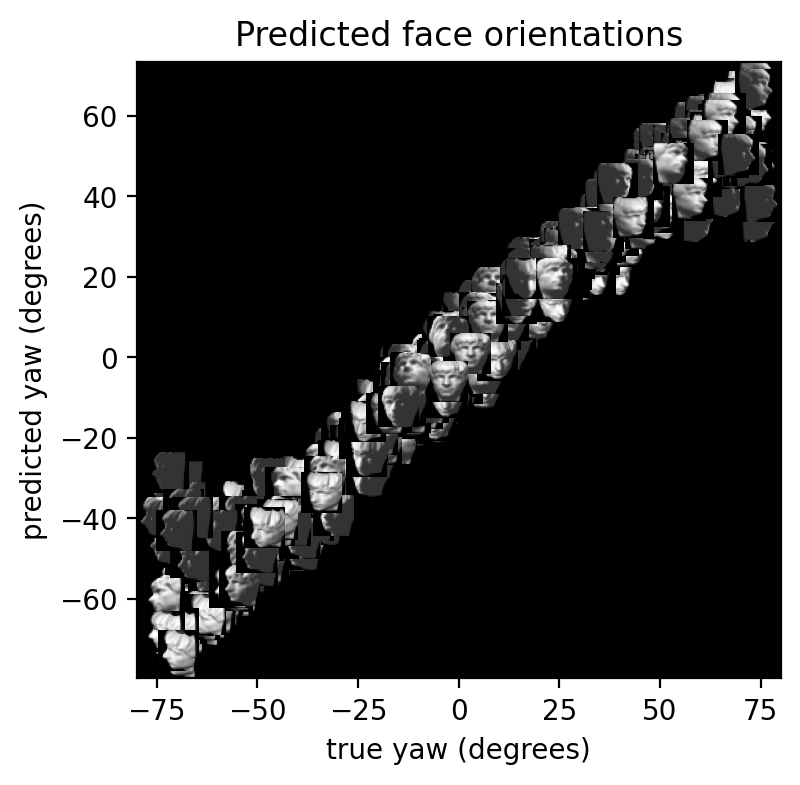

In [153]:
# if your code worked, then it should be able to predict
# what orientation a head is facing, from an image of the face
predicted_outputs = [predict(theta, faceputs[i], unflatten) for i in range(698)]
# show_faces(faceputs, np.array(predicted_outputs).reshape(-1))
show_face_predictions(faceputs, yaw_outputs, np.array(predicted_outputs).reshape(-1))
plt.gca().set_title('Predicted face orientations')

mse_error = np.sqrt(np.mean((predicted_outputs - yaw_outputs) ** 2))
print("Total mean squared prediction error: {error:4f}".format(error=mse_error))

In [154]:
# you get more marks for a more correct answer :)
with tick.marks(8):
    assert mse_error < 100

In [155]:
with tick.marks(6):
    assert mse_error < 70

In [156]:
with tick.marks(4):
    assert mse_error < 65

In [157]:
with tick.marks(2):
    assert mse_error < 60

----

If you've got this far, you've managed to build a system which can predict the head orientation from a picture of a face. All that was needed was some simple gradient descent, which optimised a function parameterised with a 33032 dimensional vector (the number of elements in `theta`).

This is not a perfect solution. It is not robust to noise, or to variations in the head shape, scale or rotation. We have no idea if it generalises well to other face images than those we trained on. The mapping we used is extremely wasteful, and ignored the fact that pixels which are close together are probably related. All of these things would be fixed in a real deep learning approach, but the the principle remains the same. We create a parameterisable function, then optimise its parameters to align the approximation with some known training examples.

## The environmental cost of machine learning

Machine learning models can consume vast amounts of computation during hyperparameter optimisation, parameter optimisation, and production. It is not uncommon for a single training run to take weeks of computation on clusters of thousands of GPUs. Running the computational infrastructure contributes to CO$_2$ emissions and thereby accelerates global heating. 

How can we quantify the amount of CO$_2$ emitted during machine learning model training?

One estimation and comparison tool is provided at [https://mlco2.github.io/impact/](https://mlco2.github.io/impact/).

Use the link provided above to estimate the kg CO$_2$ emitted during optimisation under the following assumptions:
* one optimisation run takes 7 days on a A100 PCIe 40/80GB to complete
* optimisation is repeated 100 times during hyper-parameter tuning
* Amazon Web Services is used as the cloud provider
* Compute instances are based in the Frankfurt region
* store the estimated CO2 emissions in `co2_frankfurt`
* evaluate the net CO2 impact of performing this computation in the `Canada (Central)` region instead. Store CO2 emissions in this region in `co2_canada` and the change in `co2_diff`.

In [173]:
# YOUR CODE HERE
co2_frankfurt = 2562
co2_canada = 84
co2_diff = co2_canada - co2_frankfurt

In [174]:
with tick.marks(2):
    assert(check_hash(np.array(co2_frankfurt, dtype=int), ((), 12810.0)))

In [175]:
with tick.marks(2):
    assert(check_hash(np.array(co2_canada, dtype=int), ((), 420.0)))
    assert(check_hash(np.array(co2_diff, dtype=int), ((), -12390.0)))

-----

# Submission instructions

## Before submission

* Make sure you fill in any place that says `YOUR CODE HERE` or `"YOUR ANSWER HERE"`.
* SAVE THE NOTEBOOK
* DO NOT RENAME THE NOTEBOOK OR IT WILL NOT BE MARKED.

<div class="alert alert-block alert-danger">
    
### Formatting the submission
* **WARNING**: If you do not submit the correct file, you will not get any marks.
* Submit this file **only** on Moodle. It will be named `<xxx>.ipynb`.

</div>


## Penalties (only for assessed labs)
<font color="red">
    
**Malformatted submissions**
</font>
These assignments are processed with an automatic tool; failure to follow instructions *precisely* will lead to you automatically losing two bands in grade regardless of whether the work is correct (not to mention a long delay in getting your work back). **If you submit a file without your work in it, it will be marked and you will get 0 marks.**

<font color="red">**Late submission**</font>
Be aware that there is a two band penalty for every *day* of late submission, starting the moment of the deadline.

<font color="red">
    
**Plagiarism**
</font> Plagiarism will be subject to the Plagiarism Policy. The penalties are severe.